### Custom ML model to identify local similarities ("links") with sequence profiles

Let $$X \in \{0,1\}^{B\times N\times 6 \times T \times 21}$$ be a batch of **one-hot encoded input translated sequences**,
where $B$ is `batch_size`, $N$ is the number of genomes and $T$ is the `tile_size` (in aa).
The 6 is here the number of translated frames in order (0,+),(1,+),(2,+),(0,-),(1,-),(2,-).
The 22 is here the size of the considered amino acid alphabet.


In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
import logomaker
from time import time
from tqdm import tqdm
from IPython.display import Audio

import importlib
import sequtils as su
print(importlib.reload(su))
import seq
print(importlib.reload(seq))

print(tf.__version__)

%load_ext memory_profiler

<module 'sequtils' from '/home/matthis/genomegraph/learn_specific_profiles/sequtils.py'>
<module 'seq' from '/home/matthis/genomegraph/learn_specific_profiles/seq.py'>
2.3.1
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


### Create random genomes as toy data 

In [128]:
N = 8            # number of genomes
tile_size = 334  # tile size measured in amino acids
# A tile is a consecutive subsequence of _one_ contig/scaffold/chromosome.
# Tiles should be about gene-sized.

#genome_sizes = [[210,100], [30,220,150], [230,110,120,90], [180]] # in nucleotides
#insertPatterns = ["ATGATGATG", "CCCCCCCCCCCC"]
#genomes = seq.getRandomGenomes(N, genome_sizes, insertPatterns, mutationProb=0.2, verbose=True)

genome_sizes = [[1000]] * N
                # in nucleotides
insertPatterns = ["ATGGCAAGAATTCAATCTACTGCAAATAAAGAA",
                 ] 
repeatPatterns = ['AGAGAACCTGAAGCTACTGCTGAACCTGAAAGA']
genomes, repeatTracking, insertTracking = seq.getRandomGenomes(N, genome_sizes, insertPatterns,
                                                               repeatPatterns,
                                                               mutationProb=0.1, 
                                                               repeatMultiple=range(1,20),
                                                               repeatInsert=range(1,20),
                                                               verbose=False)
print(insertTracking)

{0: {0: {'pos': [204], 'pattern': ['ATGGCAAGAATTCAATCTACAGCAAATAAGGAA']}}, 1: {0: {'pos': [290], 'pattern': ['ATTGCAAGAATTCAGTCTACAGCCAATAAAGAA']}}, 2: {0: {'pos': [285], 'pattern': ['ATAGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 3: {0: {'pos': [444], 'pattern': ['ATGGCAAGAATACAATCTACTGCGAATAAAGAC']}}, 4: {0: {'pos': [553], 'pattern': ['ATGGCAAGCATTCAATCTACTGCAAATAAAGAA']}}, 5: {0: {'pos': [227], 'pattern': ['ATAGCAAGCATACAATCTACTGCAAATAAAGAA']}}, 6: {0: {'pos': [731], 'pattern': ['ATTGCAAGAATTCACTCTACAGCCAATAAAGAA']}}, 7: {0: {'pos': [425], 'pattern': ['ATTGCAAGAATACAATCCACTGCAAATAACGAG']}}}


In [270]:
def printExpectedPatterns():
    desiredPatternAA, repeatPatternAA = None, None
    if insertPatterns is not None:
        desiredPatternAA = []
        for pattern in insertPatterns:
            desiredPatternAA.extend(su.six_frame_translation(pattern))

        print("Desired:", desiredPatternAA)

    if repeatPatterns is not None:
        repeatPatternAA = []
        for pattern in repeatPatterns:
            repeatPatternAA.extend(su.six_frame_translation(pattern))

        print("Repeat:", repeatPatternAA)
        
    return desiredPatternAA, repeatPatternAA

desiredPatternAA, repeatPatternAA = printExpectedPatterns()

Desired: ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']
Repeat: ['REPEATAEPER', 'ENLKLLLNLK', 'RT*SYC*T*K', 'SFRFSSSFRFS', 'LSGSAVASGS', 'FQVQQ*LQVL']


---

#### Interlude: Magic Commands

https://towardsdatascience.com/speed-up-jupyter-notebooks-20716cbe2025

`%time command` prints runtime of command  
`%prun command` profiler for command, what steps take how much time? Adds overhead  
`%memit command` peak memory usage and memory increment  
`%mprun command` memory profiling

---

In [130]:
# Load Real Data
if False:
    from Bio import SeqIO
    import os
    
    files = ['hg38.fa', 'mm10.fa', 'hetGla2.fa', 'macFas5.fa']
    genomes = [[] for _ in range(len(files))]
    datapath = "/nas-hs/projs/seedFinding/data/20210517_flanked/"
    def loadRealGenomes(genomes=genomes):
        for i in range(len(files)):
            genomes[i].extend([str(seq.seq) for seq in SeqIO.parse(os.path.join(datapath, files[i]), 'fasta')])
            
    %memit loadRealGenomes()
    
    # load pickled Q to safe time
    Qfile = os.path.join(datapath, "backgroundAAFreqs.pkl4")
    if not os.path.isfile(Qfile):
        print("Getting Q")
        %time Q = seq.backGroundAAFreqs(genomes, True)
        with open(Qfile, 'wb') as fh:
            pickle.dump(Q, fh, protocol=4)
            
    else:
        with open(Qfile, 'rb') as fh:
            Q = pickle.load(fh)
    
else:
    %time Q = seq.backGroundAAFreqs(genomes, True)

background freqs:  15968.0 *
C 0.0304
K 0.0324
E 0.0346
W 0.0121
T 0.0587
G 0.0650
Y 0.0249
A 0.0762
I 0.0359
N 0.0270
V 0.0587
H 0.0259
S 0.0971
D 0.0295
F 0.0330
M 0.0127
R 0.1080
L 0.0955
P 0.0651
Q 0.0323
* 0.0448
CPU times: user 16 ms, sys: 8 ms, total: 24 ms
Wall time: 21.8 ms


For seedFinding data on gs3

    background freqs:  765611260.0 *
    C 0.0329
    K 0.0412
    E 0.0332
    W 0.0165
    T 0.0578
    G 0.0558
    Y 0.0334
    A 0.0510
    I 0.0546
    N 0.0361
    V 0.0578
    H 0.0321
    S 0.0929
    D 0.0280
    F 0.0406
    M 0.0172
    R 0.0710
    L 0.1039
    P 0.0558
    Q 0.0352
    * 0.0527
    CPU times: user 7min 14s, sys: 1.69 s, total: 7min 16s
    Wall time: 7min 16s

In [131]:
print(len(genomes), len(genomes[0]), len(genomes[0][0]))

8 1 1000


In [132]:
# uniform background distribution appears to be rather better
#Q = np.ones(21, dtype=np.float32)/21

#### Read in the genome

In [133]:
genomes[0][0][0:100]

'TTGGTTGTCTATAATGCAGCTGCGCATGAACCGGCTTCGGCCGCTACGACATAGAACGTTGAGCTGCATCAGAAGGAACCGGAGAGGAGCTGCGCATGAA'

six frame translation in batch mode:

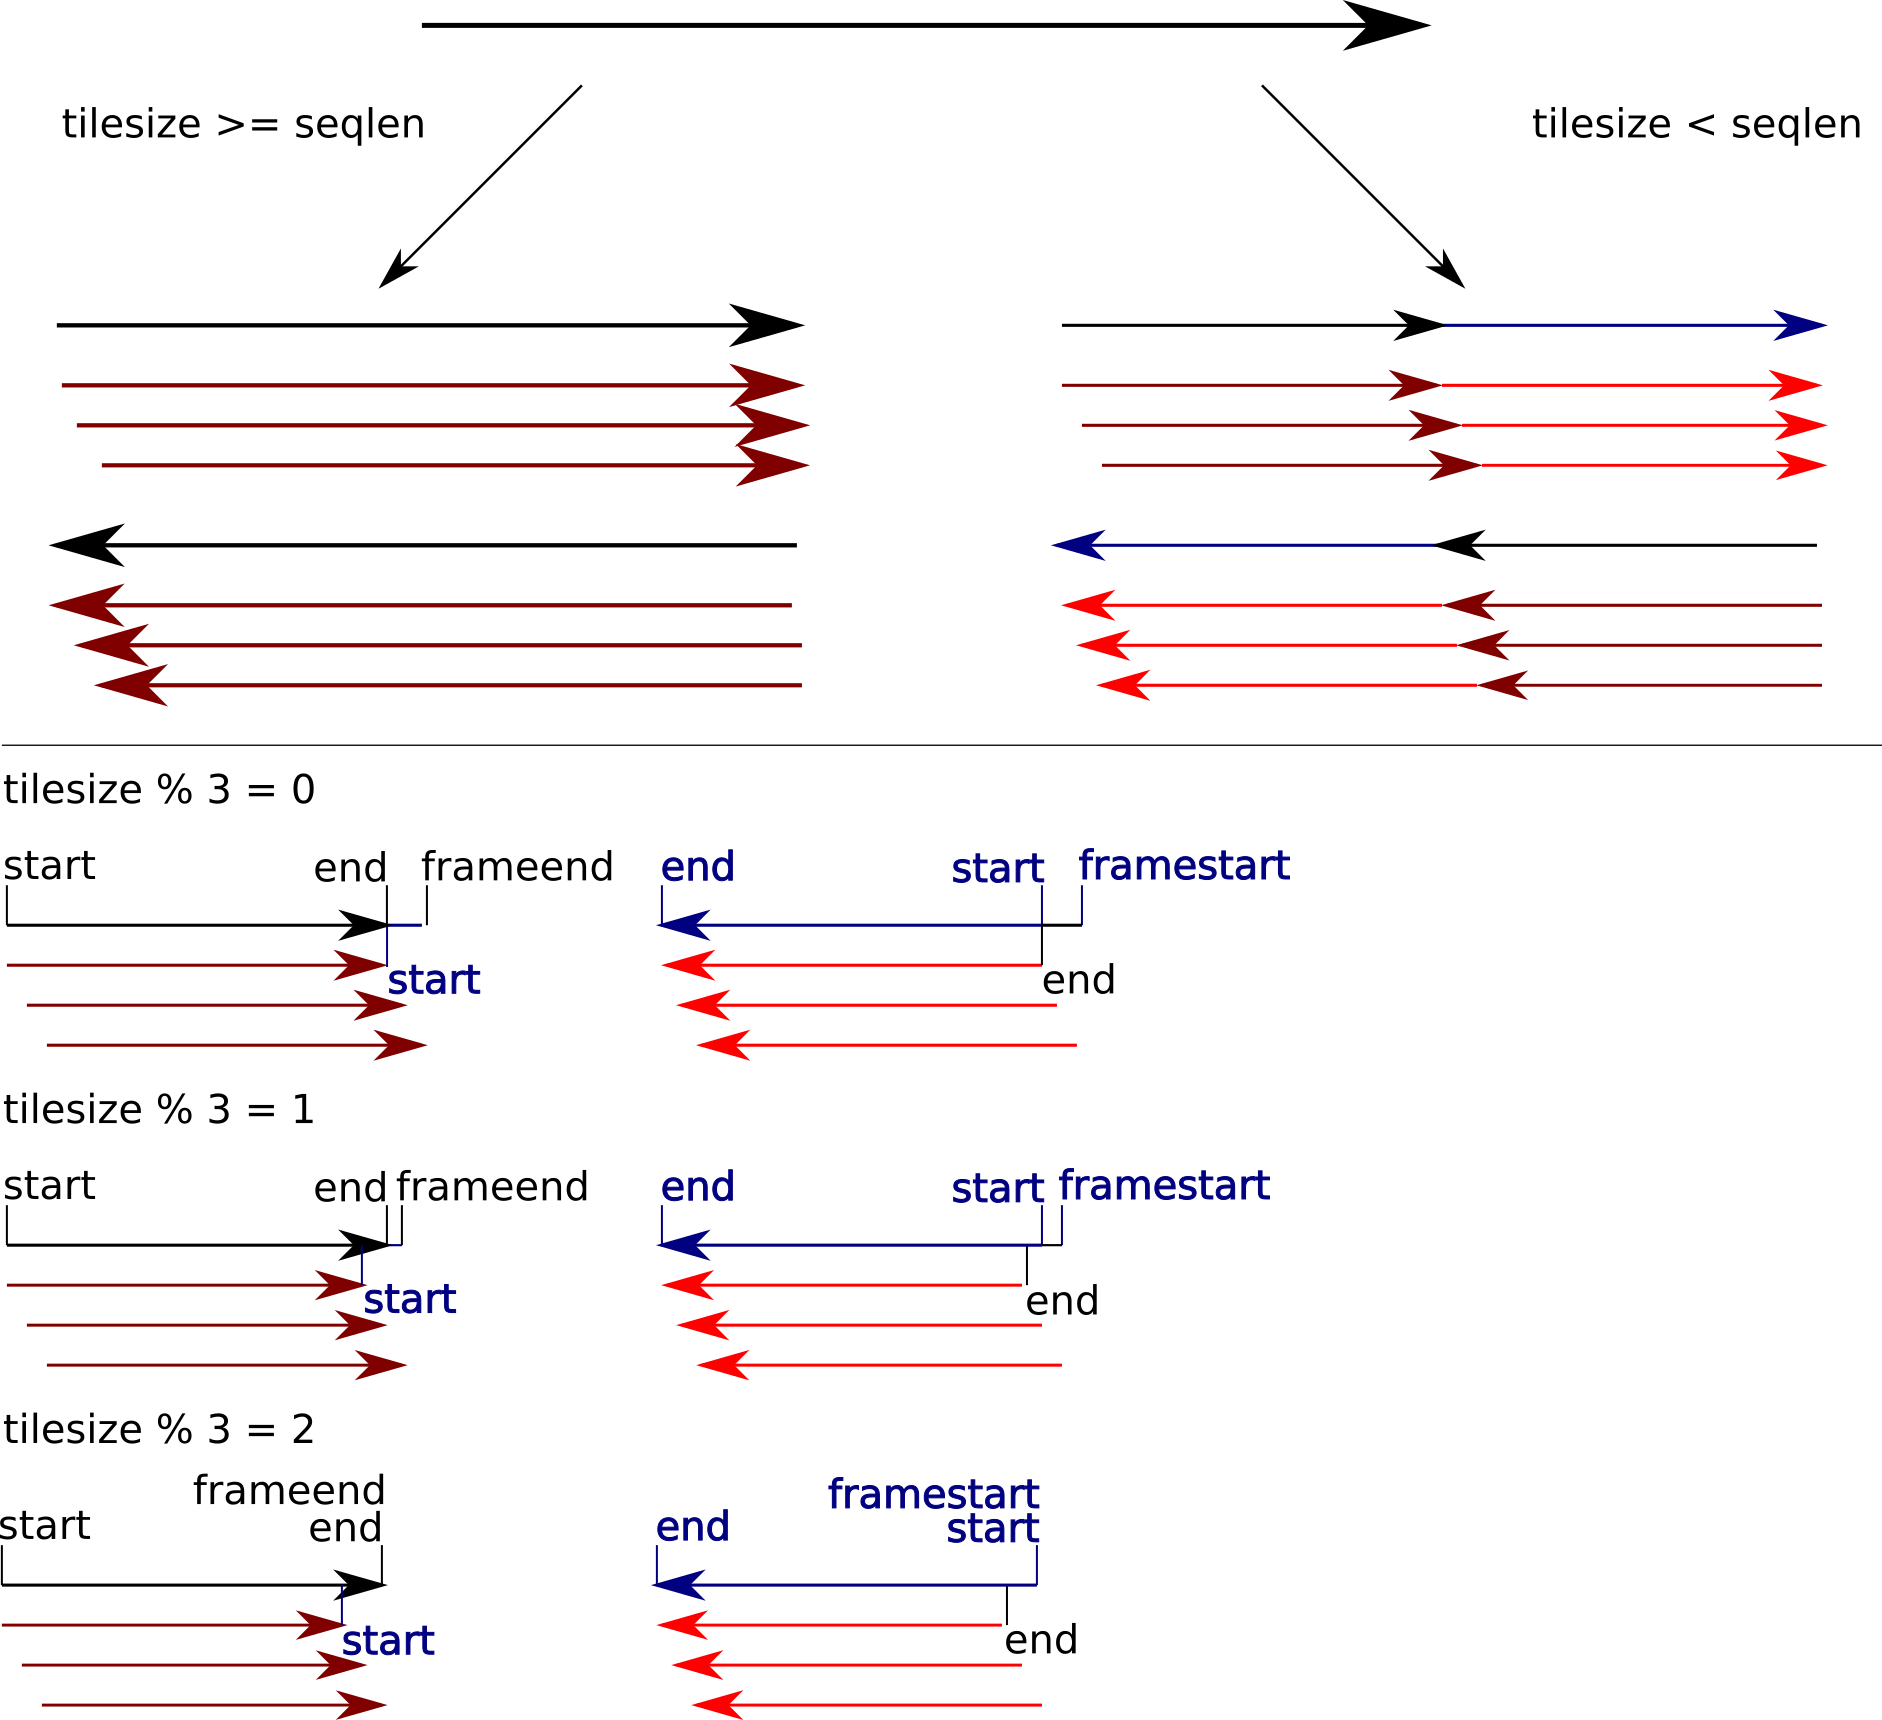

In [134]:
# manually handle reverse complements, assume that len(S) = x*3 + 2
def three_frame_translation(S):
    assert len(S) % 3 == 2, str(len(S))+" % 3 = "+str(len(S)%3)+"\n\n'"+str(S)+"'"
    T = []
    for f in range(3): # frame
        prot = ""
        for i in range(f, len(S)-3+1, 3):
            codon = S[i:i+3]
            if codon not in su.genetic_code: # real sequences may contain N's or softmasking or ambiguous bases
                prot += ' '                  # use null aa in that case
            else:
                prot += su.genetic_code[codon]
        T.append(prot)
    return T

def translateSequences(fwdSeq, pre_rcSeq, startPadding: bool):
    rcSeq = pre_rcSeq[::-1].translate(su.rctbl)
    if startPadding:
        rcSeq += '  ' # add padding
        
    fwdSeq += ' '*(2-(len(fwdSeq)%3)) # add padding such that len%3==2
    rcSeq = ' '*(2-(len(rcSeq)%3)) + rcSeq

    # some nucleotides are part of both neighboring tiles
    aa_seqs_fwd = three_frame_translation(fwdSeq)
    aa_seqs_rc  = three_frame_translation(rcSeq)
    aa_seqs_fwd.extend(aa_seqs_rc)
    return aa_seqs_fwd

# try using a generator to get genome batches
#def createBatch(genomes, ntiles, aa_tile_size: int):
def createBatch(ntiles, aa_tile_size: int, genomes = genomes):
    assert aa_tile_size >= 1, "aa_tile_size must be positive, non-zero (is: "+str(aa_tile_size)+")"
    tile_size = aa_tile_size * 3 # tile_size % 3 always 0
    N = len(genomes)
    state = [{'idx': 0, 'pos': 0, 'exhausted': (len(seqs) == 0)} for seqs in genomes]
    while not all(s['exhausted'] for s in state):
        X = np.zeros([ntiles, N, 6, aa_tile_size, su.aa_alphabet_size], dtype=np.float32)
        I = np.eye(su.aa_alphabet_size + 1) # for numpy-style one-hot encoding
        for t in range(ntiles):
            for i in range(N):
                if state[i]['exhausted']:
                    continue
                    
                sidx = state[i]['idx']
                slen = len(genomes[i][sidx])
                
                start = state[i]['pos']
                end = min(slen, start+tile_size)
                framestart = max(0, start-2)
                frameend = min(slen, end+2)
                assert start < end
                assert framestart < end
                
                # update state
                state[i]['pos'] = end
                if end == slen:
                    state[i]['idx'] += 1
                    state[i]['pos'] = 0
                    
                if state[i]['idx'] == len(genomes[i]):
                    state[i]['exhausted'] = True
                                
                # translate and add tiles
                sequence = genomes[i][sidx]
                if type(sequence) is not str:
                    sequence = str(sequence) # with tf, input are byte-strings and need to be converted back
                    
                aa_seqs = translateSequences(sequence[start:frameend], 
                                             sequence[framestart:end],
                                             (start == 0))
                for frame in range(6):
                    aa_seq = aa_seqs[frame]
                    assert len(aa_seq) <= aa_tile_size, str(len(aa_seq))+" != "+str(aa_tile_size)+", start, end, frameend, slen, tile, genome, frame: "+str((start, end, frameend, slen, t, i, frame))                        
                    x = su.to_idx(aa_seq, su.aa_idx)
                    num_aa = x.shape[0]
                    if (num_aa > 0):
                        one_hot = I[x] # here still aa_alphabet_size + 1 entries
                        # missing sequence will be represented by an all-zero vector
                        one_hot = one_hot[:,1:] 
                        X[t,i,frame,0:num_aa,:] = one_hot
                        
        yield X

---

_**Test Batch Generator**_

Retranslate and assemble all batches, compare to translations of genome sequences

_So far, fails for seedFinding data, no idea why_

In [135]:
# limit test to subset of sequences for large genomes
limit = 10000
if max([sum([len(s) for s in genome]) for genome in genomes]) > limit:
    testgenome = [[] for _ in range(len(genomes))]
    i = 0
    while max([sum([len(s) for s in genome]) for genome in testgenome]) < limit:
        for g in range(len(genomes)):
            if i < len(genomes[g]):
                if len(genomes[g][i]) > limit:
                    testgenome[g].append(genomes[g][i][0:limit])
                else:
                    testgenome[g].append(genomes[g][i])
                        
        i += 1
else:
    testgenome = [[s for s in genome] for genome in genomes]
    
# translate and concatenate whole testgenome aa sequences
genome_aa = [[""]*6 for _ in range(len(testgenome))]
for g in range(len(testgenome)):
    for i in range(len(testgenome[g])):
        aa_seqs = su.six_frame_translation(testgenome[g][i])
        for f in range(len(aa_seqs)):
            genome_aa[g][f] += aa_seqs[f].replace(' ', '')#.lstrip().rstrip()

# prepare generator testing
rev_aa_idx = dict((i,c) for i,c in enumerate(su.aa_alphabet))

def to_aa(onehot):
    assert onehot.shape[1] == 21, str(onehot.shape)
    aa_seq = ""
    for c in range(onehot.shape[0]):
        if np.max(onehot[c,:]) != 1:
            continue
        else:
            aa_idx = np.argmax(onehot[c,:])
            assert onehot[c, aa_idx] == 1, str(onehot[c,:])+", "+str(aa_idx)+", "+str(onehot[c,aa_idx])
            aa_idx += 1 # argmax + 1 as in translation, empty aa is cut out
            aa_seq += rev_aa_idx[aa_idx]
        
    return aa_seq#.lstrip().rstrip()

X_to_genome_aa = [[""]*6 for _ in range(len(testgenome))] # for each genome and each frame, concatenate translated aa seqs

# create generator
#Xgen = createBatch(testgenome, 5, tile_size)
Xgen = createBatch(5, tile_size, genomes = testgenome)

# iterate through generator, transforming and concatenating aa sequences
# X.shape [ntiles, N, 6, tile_size, su.aa_alphabet_size]
for X in tqdm(Xgen):
    for t in range(X.shape[0]):
        for g in range(X.shape[1]):
            for f in range(X.shape[2]):
                x_aa_seq = to_aa(X[t,g,f,:,:])
                if f < 3:
                    X_to_genome_aa[g][f] += x_aa_seq
                else:
                    #fr = 5 if f == 3 else f-1 # for some reason, frames rotate in generator compared to direct translation
                    #X_to_genome_aa[g][fr] = x_aa_seq + X_to_genome_aa[g][fr]
                    X_to_genome_aa[g][f] = x_aa_seq + X_to_genome_aa[g][f]
            
# compare aa sequences
assert np.all(genome_aa == X_to_genome_aa), str(genome_aa)+"\n\n!=\n\n"+str(X_to_genome_aa)

1it [00:01,  1.28s/it]


AssertionError: [['LVVYNAAAHEPASAATT*NVELHQKEPERSCA*TGFGRYDIER*AASEGTGEALYATLGAYGKEF*SGMARIQSTANKEA*LRHQRSKVAITA*IEYASVTVTCSVV**SILAASTHDGLGRGSKACLSAREILIKVWKV*LGVTTDLSMVTVSSVTGLALGAFRSSAAVSKERADCALASAGMCFAVAIGSESGGASRRSKFGEGDLWIRSNAEIKAEGPADVQSSAKETYG*EVTLKSYRTSAGRI*V*CCSFERESRLRFSISGNVLRGRHWL*KRRGQQTFKVRRRRPMDKK*R*NHKK*R*NRNPSGGSNSHH**AATKRVTDVPSFV', 'WLSIMQLRMNRLRPLRHRTLSCIRRNRRGAAHEPASAATT*NVELHQKEPERPFTPL*APTGKNSKAEWQEFNLQQIRKLSSDTKDPK*Q*PPE*NTPASP*RAQ*CDEAYLLPPRTTALEEDQKHASAREKYL*RYGKYS*E*LQTLAW*PYRQLPD*RWAHLGLVLQFRKREQTAL*HQRECASRSPLALKAEGPADVQSSAKETYG*EVTLKSKRRGQQTFKVRRRRPMDKK*R*NLTGLALGAFRSSAAVSKERADCALASAGMCFAVAIGSESGGASRRSKFGEGDLWIRSNAEIIRSNAEIEIQAAVLIAIISRRLPNG*PTYLHSS', 'GCL*CSCA*TGFGRYDIER*AASEGTGEELRMNRLRPLRHRTLSCIRRNRRGPLRHFRRLRERILKRNGKNSIYSK*GSLAQTPKIQSSNNRLNRIRQRHRNVLSSVMKHTCCLHARRPWKRIKSMPQRARNTYKGMESIVRSNYRP*HGNRIVSYRTSAGRI*V*CCSFERESRLRFSISGNVLRGRHWL*KRRGQQTFKVRRRRPMDKK*R*NQSGGASRRSKFGEGDLWIRSNAEILPD*RWAHLGLVLQFRKREQTAL*HQRECASRSPLALKAEGPADVQSSAKETYG*EVTLKS*EVTLKSKSKRRF**PSLVGGYQTGNRRTFIR', 'RRMKVRRLPVW*PPTNDGY*NRRLDFDFSVTSYDFSVTSYP*VSFAEL*TSAGPSAFRANGDREAHSR*C*SAVCSLFRNCSTRPKCAQR*SGKISALLLIHRSPSPNFERLLAPPL*FQRYFLSIGLLRRTLNVCWPLRFQSQWRPRSTFPLMLKRSLLSLSKLQH*T*MRPALVR*LTIRLPC*GL*LLLTILSIPL*VFLAR*GMLLILFQGRRAWRQQVCFITLLSTLR*RWRILFRRLLLLWIFGV*AKLPYLL*IEFLPFRFRILSRRRLKWRKGPLRFLLMQLNVLCRSGRSRFMRSSSPVPSDAAQRSMS*RPKPVHAQLHYRQP', 'DE*RYVGYPFGSRLLMMAIRTAAWISISALLLMISALLLIHRSPSPNFERLLAPPLSEPMATAKHIPADAKAQSALSFETAALDLNAPSASPVRFQRYFLSIGLLRRTLNVCWPLRFDFSVTSYP*VSFAEL*TSAGPSAFRANGDREAHSR*C*SAVCSLFRNCSTRPKCAQR*SGN*RYGYHAKVCSYS*LYFPYLYKYFSRAEACF*SSSKAVVRGGSKYASSHY*ARYGDAGVFYSGGYCYFGSLVSELSFLICCRLNSCHSALEFFPVGA*SGVKGLSGSF*CSSTFYVVAAEAGSCAAPLRFLLMQLNVLCRSGRSRFMRSCIIDNQ', 'TNEGTSVTRLVAAY**WLLEPPLGFRFQRYFL*FQRYFLSIGLLRRTLNVCWPLRFQSQWRPRSTFPLMLKRSLLSLSKLQH*T*MRPALVR*DFSVTSYP*VSFAEL*TSAGPSALISALLLIHRSPSPNFERLLAPPLSEPMATAKHIPADAKAQSALSFETAALDLNAPSASPVTDDTVTMLRSVVTPNYTFHTFISISRALRHAFDPLPRPSCVEAASMLHHTTEHVTVTLAYSIQAVIATLDLWCLS*ASLFAVD*ILAIPL*NSFP*APKVA*RASPVPSDAAQRSMS*RPKPVHAQLLSGSF*CSSTFYVVAAEAGSCAAAL*TT'], ['LRLCLKLNKIP*RYLASVIRVRMVAAKSVIGSKQETRSTAVSCWVVELGSLFK*YQVYVRTTSERYLASVIRVRMVAAKSVIGSKQETRSTAVSCWVLQEFSLQPIKKVYVRTTSEG*IITLAILSSV*RVELKSTSTRRRQSLY*PCDSDLKCGKRSTWVSDDRPWTGS*CGKIGVSCPV*RAMVTP*GV*A*SEQWR*VVGAG*DR*GWFTAGCRRGESSSVSTLTENSACIRISLYVVTLAGPATAAVPATAAVMVHSRV*ARGVFICQHTYRKLRLH*NFTLRGDPRRTRNGRGVHEFRCSTEVM*AHA*TRSRLEHPGDPLPAVSISF', 'YDFALN*IRSHRDTSHPSSESEWWRQNLSLDLNKKRVAPQYRVGWWN*EVYLNDTRCTSEPLARDTSHPSSESEWWRQNLSLDLNKKRVAPQYRVGYCKNSVYSQ*RRCTSEPLARARSSP*RFSVAFDA*N*SQHPHEDDSPSTDLATPT*SAEKEAPGSQTTDHGQVASAGRSGYPALYDARW*PPKAYERDPNNGVKLSEPAKTDRDGSQQGVGAGSLHLSAHLQKTPPALEFHFTW*PSQDPQRPRCPQRPR*WFTAGCRRGESSSVSTLTENSACIRISLYVVTLAGPATAAVCTSSGVPLK*CRLTREQGQG*STLVTLYPQCPYLS', 'TTLP*TE*DPIEIPRIRHQSQNGGGKICHWI*TRNA*HRSIVLGGGIRKSI*MIPGVRQNH*REIPRIRHQSQNGGGKICHWI*TRNA*HRSIVLGIARIQSTANKEGVRQNH*RGLDHHLSDSQ*RLTRRIKVNIHTKTTVPLLTLRLRPKVRKKKHLGLRRQTMDR*LVREDRGILPCMTRDGNPLRRMSVIRTMALSCRSRLRQIGMVHSRV*ARGVFICQHTYRKLRLH*NFTLRGDPRRTRNGRGARNGRGDGSQQGVGAGSLHLSAHLQKTPPALEFHFTW*PSQDPQRPRCARVPVFH*SNVGSRVNKVKVRAPW*PFTRSVHIF', '*KIWTLRVKGHQGALTLTLFTREPTLLQWNTGTRAHRGRCGSCEGHHVK*NSNAGGVFCKCADR*RLPAPTPCCEPSPRPLRAPRPLRVLRGSPRKVKF*CRRSFL*VC*QMKTPRAYTLL*TIPICLSRLRQLNAIVRITLIRLRGLPSRVIQGRIPRSSRTSYLSMVCRLRPRCFFFRTLGRSRKVSRGTVVFVWMLTLILRVKRY*ESLR**SSPR*WF*RTPSLLAVD*ILAIPNTILRCYAFLV*IQ*QILPPPF*L**RMRGISR*WF*RTPGII*IDFLIPPPNTILRCYAFLV*IQ*QILPPPF*L**RMRGISMGSYSV*GKVV', 'ERYGHCG*RVTRVL*P*PCSRVSLHYFSGTPELVHTAAVAGPARVTT*SEILMQAEFSVSVLTDEDSPRLHPAVNHHRGRCGHRGRCGSCEGHHVK*NSNAGGVFCKCADR*RLPAPTPCCEPSLSVLAGSDNLTPLFGSRSYALGGYHRASYRAGYPDLPALATCPWSVV*DPGASFSAL*VGVARSVEGLSSSCGC*L*FYASNATENR*GDDLALASGSDVHLLYWL*TEFLQYPTRYCGATRFLFRSNDRFCRHHSDSDDGCEVSLASGSDVHLVSFK*TS*FHHPTRYCGATRFLFRSNDRFCRHHSDSDDGCEVSLWDLIQFKAKS*', 'KDMDTAGKGSPGCSNLDLVHA*AYITSVEHRNSCTPRPLRVLRGSPRKVKF*CRRSFL*VC*QMKTPRAYTLL*TITAAVAGTAAVAGPARVTT*SEILMQAEFSVSVLTDEDSPRLHPAVNHPYLS*PAPTT*RHCSDHAHTP*GVTIARHTGQDTPIFPH*LPVHGLSSETQVLLFPHFRSESQGQ*RDCRLRVDVDFNSTRQTLLRIAKVMI*PSLVVLTYTFFIGCRLNSCNTQHDTAVLRVSCLDPMTDFAATILTLMTDARYLSLVVLTYTWYHLNRLPNSTTQHDTAVLRVSCLDPMTDFAATILTLMTDARYLYGILFSLRQSR'], ['QVNIFHPPR*HDRDGCFS*LFITPS*WTYSGRLHYILTQGDRILLGACITLGACITF*LKGIEFSFAFRAARGTAYIG*TCSRGAFETRVCPLGAIARIQSTANKESFAFRAARGTAYIG*TCSRGAFETRVCPCDMESGRLHYILTQGDRILVCLQSCEGHSLHRLNMFPRRIRNTCLPLRHGV*RTRMGLPAERLGSMRA*GGGA*RYRLVQADVPLGPWLMQRQHRNQTLLGLRTNTRRSNLAQAQKRIKWLQTRSAVLCGRKCLWAPHGQNYKQPRKTEILLYSLAMRAIAHIHYRVHPKKPFH*RIGLEPVLRVSYLSMGVSVWGQG*', 'RSIYFIRLGNMTVMGAFLDSLSRRVDGHILGACITF*LKGIEFSWALALHWALALHSDSRGSNSRLPSELRGAQLTSAEHVPEAHSKHVSALWAL*QEFNLLQIKNRLPSELRGAQLTSAEHVPEAHSKHVSALATWSLGACITF*LKGIEFSFAFRAARGTAYIG*TCSRGAFETRVCPCDMEFDGRGWVCRRRG*GR*GRRVEARKGIV*SRRMCRWVRG*CSGSTVTRPC*G*GQTPAVRTWRKRKSV*SGSRPAVLCCAAVSASGLRTVRTISNRGRRKSCFIVSP*GQ*RTFTIGFTLRNPSISVSGWNRC*ECLISVWGSQYGGRVR', 'GQYISSA*VT*P*WVLFLTLYHAELMDIFWALALHSDSRGSNSPGRLHYTGRLHYILTQGDRILVCLQSCEGHSLHRLNMFPRRIRNTCLPSGRYSKNSIYCK*RIVCLQSCEGHSLHRLNMFPRRIRNTCLPLRHGVWALALHSDSRGSNSRLPSELRGAQLTSAEHVPEAHSKHVSALATWSLTDADGSAGGEARVDEGVGWRRVKVSSSPGGCAVGSVVDAAAAP*PDPVRAKDKHPPFELGASAKAYKVAPDPQCCAVRP*VPLGSARSEL*ATEEDGNLAL*SRHEGNSAHSLSGSP*ETLPLAYRVGTGAESVLSQYGGLSMGAGL', 'SNPAPILRPPY*DKTLSAPVPTRYANGRVS*GEPDSECALLPSWRDYKARFPSSSVAYSSDRAEPRGTYGRTAQHCGSGATLYAFALAPSSNGGCLSLALTGSGYGAAAASTTDPTAHPPGLDDTFTRLHPTPSSTLASPPADPSASVKLHVARADTCFECASGTCSADVSCAPRSSEGKREFDPLESECNASAQTPCRKGRHVFRMRLGNMFSRCKLCPSQL*RQTILYLQ*IEFLL*RPEGRHVFRMRLGNMFSRCKLCPSQL*RQTRIRSP*VRM*CKRPV*CKRPGEFDPLESECNASAQNMSINSA**RVKKSTHHGHVT*ADEIY*P', 'LTLPPY*DPHTEIRHSQHRFQPDTLMEGFLRVNPIVNVRYCPHGETIKQDFRLPRLLIVLTVRSPEALTAAQHSTAGLEPLYTLLRLRQVRTAGVCP*P*QGLVTVLPLHQPRTQRHIRLD*TIPLRASTLRPHRP*PLRRQTHPRPSNSMSQGQTRVSNAPREHVQPM*AVPLAALKANENSIPLSQNVMQAPRLHVARADTCFECASGTCSADVSCAPRSSEGKRFFICSRLNSCYSAQRADTCFECASGTCSADVSCAPRSSEGKREFDPLESECNASAQCNASAQENSIPLSQNVMQAPRICPSTRRDKESRKAPITVMLPRRMKYIDL', '*PCPHTETPILR*DTLSTGSNPIR*WKGFLG*TR**MCAIALMARL*SKISVFLGCL*F*PCGAQRHLRPHSTALRVWSHFIRFCACAKFERRVFVLSPNRVWLRCCRCINHGPNGTSAWTRRYLYAPPPYALIDPSLSAGRPIRVRQTPCRKGRHVFRMRLGNMFSRCKLCPSQL*RQTRIRSP*VRM*CKRPDSMSQGQTRVSNAPREHVQPM*AVPLAALKANDSLFAVD*ILAIAPRGQTRVSNAPREHVQPM*AVPLAALKANENSIPLSQNVMQAPSVMQAPRRIRSP*VRM*CKRPEYVHQLGVIKSQEKHPSRSCYLGG*NILT'], ['HMSMDSKTSV*GKLYSGSIPHHLYPTIPSRPTGRACKTRTGCKGVEGGCLISL*RDAGDGIGNRAGETP*VSVTFKVRTSEAGAALKVENCCGRCRRAGRGPGLVFACYKQYFWSAGDVCMGKFERTGACARLAVKGVAESGREDPWSMARIQSTANKDPSDVKELTATVI*GVSIRASASGLAGSNVTS*SVIGRANGRVGLPTSAKMAQVTSAWANSKEQARAHGSQ*RASLNQGGKTLGASVTERNSTSPSHPTSRN*QQR*FEGYRSEPPPVA*RAQTSRLNL*SGVQTGGSDYLPQPR*REGRITYLSQDDLPQPR*ALLIVAVSYVT', 'T*VWILRHRSRGSYTRVLYPTIYTPPFPADPPGGHVKPVQDVKG*RAAA**AFDETQETESETAPERRLRSVLRSKCGPQKQALRSRWRTAAADVGAQEGGLD*YSRATNNTFGAQVTSAWANSKEQARAHGSQ*RASLNQGGKTLGAWQEYNLLRIKTHPTSRN*QQR*FEGYRSEPPPVA*RAQTSRLNL*SGVQTGGSDYLPQPRWRR*RLHGQIRKNRRVRTARSKGRR*IRAGRPLEPRLPSETVRRHPIRRQGTDSNGNLRGIDPSLRQWLSGLKRHVLICNRACKREGRITYLSQDDGRVGLPTSAKMTYLSQDELYS*LRFRTLQ', 'HEYGF*DIGLGEAILGFYTPPSIPHHSQQTHRAGM*NPYRM*RGRGRLPNKPLTRRRRRNRKPRRRDALGQCYVQSADLRSRRCAQGGELLRPM*ARRKGAWISIRVLQTILLERR*RLHGQIRKNRRVRTARSKGRR*IRAGRPLEHGKNTIYCE*RPIRRQGTDSNGNLRGIDPSLRQWLSGLKRHVLICNRACKREGRITYLSQDGAGDVCMGKFERTGACARLAVKGVAESGREDPWSLGYRAKQYVAIPSDVKELTATVI*GVSIRASASGLAGSNVTS*SVIGRANGRVGLPTSAKMTGGSDYLPQPR*PTSAKMSSTHSCGFVRY', 'L*RTKPQL*VELILAEVGHLG*GR*SDPPVILAEVGNPTLPFARPITD*DVTFEPAKPLAEARIDTPQITVAVSSLTSDGMATYCFAR*PRLQGSSRPDSATPFTASRAHAPVLSNLPMQTSPAPSWLR*VIRPSRLHARLQIKT*RLSPLSHWRRLGSIPLKLPLLSVP*RRMGLYSQ*IVFLPCSKGLPALIQRRPLLRAVRTRLFFRICPCRRHLRSKSIVCSTRILIQAPFLRAYIGRSSSPP*AQRLLLRSAL*T*H*PKASLRRGFRFRLLRLVKGLLGSRPLPLYILYGFYMPARWVCWEWWGIDGGV*NPSIASPRPMS*NPYSC', 'CNVRNRNYE*SSSWLR*VILAEVGNPTLPSSWLR*VIRPSRLHARLQIKT*RLSPLSHWRRLGSIPLKLPLLSVP*RRMGWRRTVSLGNRGSKGLPALIQRRPLLRAVRTRLFFRICPCRRHLRHLG*GR*SDPPVCTPDYRLRRDV*AR*ATGGGSDRYPSNYRCCQFLDVGWVFIRSRLYSCHAPRVFPP*FSDALYCEPCARACSFEFAHADVTCAPKVLFVAREY*SRPPSCAPTSAAAVLHLERSACF*GPHFERNTDLRRLSGAVSDSVSCVSSKAY*AAALYPFTSCTGFTCPPGGSAGNGGV*MVGYRTRV*LPLDRCLRIHTHV', 'VTYETATMSRAHLG*GRSSWLR*VIRPSRHLG*GR*SDPPVCTPDYRLRRDV*AR*ATGGGSDRYPSNYRCCQFLDVGWDGDVLFRSVTEAPRVFPP*FSDALYCEPCARACSFEFAHADVTCAILAEVGNPTLPFARPITD*DVTFEPAKPLAEARIDTPQITVAVSSLTSDGSLFAVDCILAMLQGSSRPDSATPFTASRAHAPVLSNLPMQTSPALQKYCL*HANTNPGPLPARLHRPQQFSTLSAAPASEVRTLNVTLT*GVSPARFPIPSPASRQRLIRQPPSTPLHPVRVLHARPVGLLGMVGYRWWGIEPEYSFP*TDVLESILM'], ['AAMI*HGRTRVQSCHFSRTRVAIDSRRTRETRILSQICI*TNKLRRNSLGRENSVLK*FRALSRRM*GPF*RLHAST*LSSIIRKRKLLLNCNTRRAVPNHHLMGMERVTMRPC*PCRTLSHRWYWTLRKGSLDSHRM*PGSG*ISFLPLERKRIRQNLPKRRVGRRTKKPFNGRRYRTFHRQSNGKHSIYCK*RI*ATVGIGRCVKGV*IAIGCNLVAGRSPSYLSRENASGRTYRSVVSAEGRRNPSMGAGTGRSTGKVHTPRIVSGRGDETPVQDVPPAKYTPLGLYPGAETAGTGRSTGKVHTPRIVSGRGDPAKYTPLGLYPGAETRE', 'QQ*FDMAVRGCRVVTSVELVWL*ILAAPEKQEF*ARFASRRINFDVIVSVGKIAS*SSFEP*VGGCEAPFNAYMQALS*VA*FESVSFCLTVTRDERYRTTTSWAWSG*RCAPASPAGL*ATVGIGRCVKGV*IAIGCNLVAGRSPSYLSRENASGRTYRSVVSAEGRRNPSMGAGTGRSTGKVMASIQSTANKESKPPLVLDAA*REFR*P*DVTW*RVDLLPTSREKTHQAELTEASCRPKDEETLQWAPVQDVPPAKYTPLGLYPGAETRRRYRTFHRQSTHP*DCIRARRPPVQDVPPAKYTPLGLYPGAETRQSTHP*DCIRARRRVR', 'SNDLTWPYAGAELSLQ*NSCGYRFSPHQRNKNFKPDLHLDE*TST**SR*GK*RLKVVSSPESADVRPLLTPTCKHLAE*HNSKA*ASA*L*HETSGTEPPPHGHGAGDDAPLLALPDSKPPLVLDAA*REFR*P*DVTW*RVDLLPTSREKTHQAELTEASCRPKDEETLQWAPVQDVPPAK*WQAFNLLQIKNLSHRWYWTLRKGSLDSHRM*PGSG*ISFLPLERKRIRQNLPKRRVGRRTKKPFNGRRYRTFHRQSTHP*DCIRARRRDAGTGRSTGKVHTPRIVSGRGDRRYRTFHRQSTHP*DCIRARRPGKVHTPRIVSGRGDA*', 'PHASPRPDTILGVCTLPGLRARIQS*GCVLCRWNVLYRRSPRPDTILGVCTLPVERPVPASRLRARIQS*GCVLCRWNVLYRRPLKGFFVLRPTRRFGKFCLMRFLSRGRKEIYPLPGYILWLSKLPLRSVQYQRWLRFFICSRLNACHYFAGGTSCTGAH*RVSSSFGRHDASVSSA*CVFSREVGRRSTRYQVTSYGYLNSLYAASNTNGGLESGRASRGASSPAPCP*GGGSVPLVSCYS*AEAYAFELCYSAKCLHVGVKRGLTSADSGLETTLRRYFPYRDYYVEVYSSRCKSGLKFLFLWCGENL*PHEFY*SDNSAPAYGHVKSLL', 'LTRLRARIQS*GCVLCRVSAPGYNPRGVYFAGGTSCTGGLRARIQS*GCVLCRWNVLYRRLVSAPGYNPRGVYFAGGTSCTGAH*RVSSSFGRHDASVSSA*CVFSREVGRRSTRYQVTSYGYLNSLYAASNTNGGLDSLFAVD*MLAITLPVERPVPAPIEGFLRPSADTTLR*VLPDAFSLER*EGDLPATRLHPMAI*TPFTQRPIPTVA*SPAGLAGAHRHPLHAHEVVVRYRSSRVTVKQKLTLSNYATQLSACM*ALKGASHPPTQGSKLL*DAIFPTETITSKFIRLDANLA*NSCFSGAARIYSHTSSTEVTTLHPRTAMSNHCC', 'SRVSAPGYNPRGVYFAGSPRPDTILGVCTLPVERPVPAVSAPGYNPRGVYFAGGTSCTGVSSPRPDTILGVCTLPVERPVPAPIEGFLRPSADTTLR*VLPDAFSLER*EGDLPATRLHPMAI*TPFTQRPIPTVA*ILYLQ*IECLPLLCRWNVLYRRPLKGFFVLRPTRRFGKFCLMRFLSRGRKEIYPLPGYILWLSKLPLRSVQYQRWLRVRQG*QGRIVTRSMPMRWWFGTARLVLQLSRSLRFRIMLLS*VLACRR*KGPHIRRLRARNYFKTLFSLPRLLRRSLFV*MQIWLKILVSLVRRESIATRVLLK*QLCTRVRPCQIIA'], ['LFSEGIRNLHRKLFDEGIRNLHRKLFDEGL*LCQRPSPRNPEPSSETVR*RTLTVPETQPYANLALSSSPRS*E*G*QAYNLLQIKKP*LNPRSAEVTVVLPSRAGDYDSAANQTDAEDEQYHTHPDGDLNV*LTVRTAEASF*VPVKRGRDNPDSDSPEWRAGQLSAVTTYRLEVVVSATTNQLTSFPRVSYAGLRPSSSERSTTSKS*PRQRTGRQTVELQLTNEERTG*SRFGLARVACRSTFSCDHVSARSGS*CYNESANVVSARKLRWS*AVFK*EKHYL*IIASPTDRSSDCGTTVNKNKNGPVVRLWNYS*QISDSDDVAYVLT*', 'YFLRESGTFIGNCSMKESGTFIGNCSMKDFNCARDPALGIRNLHRKLFDEGL*LCQRPSPTQTLLYLRARDRRSRDSKHTIYCK*RNPS*IHAPQR*LWCCRLAPGIMIQQLTRRTLRMSSIIPIPTGT*MCN*RYGQQRLVSKCL*REDGIIPIRTRPSGVQVNFQL*PRIG*KW*LVLQRIS*RRFRA*ATLVLGRLQVREALPLNHSLANGPVVRLWNYS*QMKRGRDNPDSDSPEWRAGQLSAVTTYRLEVVVSATTNQLTSFPRVSYAGLRPSSSERSTTSKS*PRQRTGRQTVELQLTKTKTDRSSDCGTTVNK*AIPMTSPMCLPS', 'IF*GNPEPSSETVR*RNPEPSSETVR*RTLTVPETQP*ESGTFIGNCSMKDFNCARDPALRKPCFIFEPEIVGVGIASIQSTANKETLVESTLRRGNCGVAVSRRGL*FSS*PDGR*G*AVSYPSRRGLECVTNGTDSRG*FLSACEERTG*SRFGLARVACRSTFSCDHVSARSGS*CYNESANVVSARKLRWS*AVFK*EKHYL*IIASPTDRSSDCGTTVNK*REDGIIPIRTRPSGVQVNFQL*PRIG*KW*LVLQRIS*RRFRA*ATLVLGRLQVREALPLNHSLANGPVVRLWNYS*QKQKRTGRQTVELQLTNKRFR*RRLCAYL', 'AR*AHRRRHRNRLFVNCSSTV*RPVRFCFC*L*FHSLTTGPLARL*FRGSASLT*RRPKTSVAYARKRR*LIRCSTNYHF*PIRGHS*KLTCTPLGRVRIGIIPSSLHLLTVVPQSDDRSVGEAMI*R*CFSHLKTA*DQRSLRAETTLADSL*H*LPLLADTWSQLKVDLHATRASPNRDYPVLSSQALRN*PLLSVPLVTHSSPRRDGYDTAHPQRPSG*LLNHNPRRETATPQLPLRSVDSTRVSLFAVDCMLAIPTPTISGSKIKQGLRRAGSLAQLKSFIEQFPMKVPDS*GWVSGTVKVLHRTVSDEGSGFLHRTVSDEGSGFPQKI', 'LGKHIGDVIGIAYLLTVVPQSDDRSVFVFVNCSSTV*RPVRWRGYDLEVVLLSLEDGLRPA*LTRGNDVS*FVVALTTTSSRYVVTAES*PARHSGESESGLSRPLFIC*L*FHSLTTGPLARL*FRGSASLT*RRPKTSVAYARKRR*LIRCSTNYHF*PIRGHS*KLTCTPLGRVRIGIIPSSLHRHLETSLCCPYR*LHIQVPVGMGMILLILSVRLVSC*IIIPGARRQHHSYLCGAWIQLGFLYLQ*IVCLLSLLLRSRARR*SKVCVGLGLWHS*SPSSNSFR*RFRIPRAGSLAQLKSFIEQFPMKVPDSFIEQFPMKVPDSLRK*', '*VST*ATSSESLIC*L*FHSLTTGPFLFLLTVVPQSDDRSVGEAMI*R*CFSHLKTA*DQRSLRAETTLADSL*H*LPLLADTWSQLKVDLHATRASPNRDYPVLSSFVNCSSTV*RPVRWRGYDLEVVLLSLEDGLRPA*LTRGNDVS*FVVALTTTSSRYVVTAES*PARHSGESESGLSRPLFTGT*KLASAVRTVSYTFKSPSGWV*YCSSSASVWLAAES*SPARDGNTTVTSAERGFN*GFFICSRLYACYPYSYDLGLEDKARFA*GWVSGTVKVLHRTVSDEGSGFLGLGLWHS*SPSSNSFR*RFRIPSSNSFR*RFRIPSEN'], ['VLRIAHRVAFRVTT*RSFTTVSQNKGDNVNGPVALDSISSL*KSGFAAGC*VGKKGVKTGSEG*SG*VGVALDSISSL*KSGFAAGC*VGKKGVKTGSEG*SG*VGTATSFSVLTSASPFGV*RSP*QHQFTLKERIRRRMLSRQERRKNRIRGLKRVSWDSHIIQRADLRQSFRRRQHRRFSSICAKTPMRLL*HRPLTPRLWLRI*LLGGNTFGTQQRQKSVALVSC*MRGPRGCMWHRRLKLQEFTLQPIKKTGTILRLMGQAQEV*GPNLP*EAMIKLPRRRLTQDSLNK*IVSEAILRVQKIR*TNRGVHRKGLEA*ISESLQTSVAL', 'SSE*RTV*HSESPPSAPSLRCPKTREIT*TVR*PLTASVHFERADSPQDAKSARKA*KPDPRAKAGKLG*PLTASVHFERADSPQDAKSARKA*KPDPRAKAGKLGQPHHSAC*PPPVLSACSVALDSISSL*KSGFAAGC*VGKKGVKTGSEG*SG*VGTATSFSVLTSASPFGVGNIAGSVPSAPRHR*GYFSTAR*LRGSGCVSDCWEGTRSAPSRGKRVWRSCLAECGGQEGACGIEG*NCKNSLYSQ*RKRGRSFVLWGKLRRSRGLTSLKRL*LSSPVGG*LKTV*TSR**AKRSCGFRRYGKRTAESTGRAWRLESVNPFKPP*HC', 'PQNSAPCSIQSHHLALLHYGVPKQGR*RKRSGSP*QHQFTLKERIRRRMLSRQERRKNRIRGLKRVSWGSP*QHQFTLKERIRRRMLSRQERRKNRIRGLKRVSWDSHIIQRADLRQSFRRVA*PLTASVHFERADSPQDAKSARKA*KPDPRAKAGKLGQPHHSAC*PPPVLSASATSPVQFHLRQDTDEVTLAPPVDSAALAAYLTAGREHVRHPAEAKECGARVLLNAGAKRVHVASKAEIARIHSTANKENGDDPSSYGASSGGLGA*PPLRGYD*APPSAADSRQFEQVDSERSDPAGSEDTVNEPRSPPEGLGGLNQ*IPSNLRSI', 'TMLRRFEGIH*FKPPSPSGGLRGSFTVSSEPAGSLRSLSTCSNCLESAADGGA*S*PLKGG*APRPPELAP*DEGSSPFSLLAVE*ILAISAFDATCTLLAPAFSKTRAPHSFASAGCRTCSLPAVRYAARAAESTGGAKVTSSVSWRRWN*TGDVADAERTGGGQHAE*CGCPNLPALALGSGFYAFLADLASCGESALSK*TDAVKGYATRRKDWRRSAR*MMWLSQLTRFSPRIRFLRLSCRLSILRRIRSFKVN*CCQGLPQLTRFSPRIRFLRLSCRLSILRRIRSFKVN*CCQGLPDRLRYLPCFGTP**RSARW*L*MLHGALF*G', 'QCYGGLKGFTDSSLQALPVDSAVRLPYLLNPQDRFAHYLLVQTVLSQPPTGELNHSLLREVRPLDLLSLPHKTKDRPRFLYWL*SEFLQFQPSMPHAPSWPPHSARHERHTLLPLLGAERVPSQQSDTQPEPRSQRAVLK*PHRCLGADGTEPAMLPTPKGLAEVSTLNDVAVPTYPL*PSDPVFTPFLPT*HPAANPLFQSELMLSRATLHAERTGGGQHAE*CGCPNLPALALGSGFYAFLADLASCGESALSK*TDAVKGYPNLPALALGSGFYAFLADLASCGESALSK*TDAVKGYRTVYVISLVLGHRSEGALGGDSECYTVRYSED', 'NATEV*RDSLIQASKPFRWTPRFVYRIF*TRRIASLTIYLFKLS*VSRRRGSLIIAS*GRLGP*TS*ACPIRRRIVPVFFIGCRVNSCNFSLRCHMHPLGPRIQQDTSATLFCLCWVPNVFPPSSQIRSQSRGVNGRC*SNLIGVLAQMELNRRCCRRRKDWRRSAR*MMWLSQLTRFSPRIRFLRLSCRLSILRRIRSFKVN*CCQGLRYTPKGLAEVSTLNDVAVPTYPL*PSDPVFTPFLPT*HPAANPLFQSELMLSRATPTYPL*PSDPVFTPFLPT*HPAANPLFQSELMLSRATGPFTLSPLFWDTVVKER*VVTLNATRCAILR'], ['*EFFPVYSSKN*SVQRRGVCAG*SSQLP*RVTTGPSTEQLAAGTSRLPPHADQRSKAPQ*AVQ*QYKGAAEVSH*NTEPSQPYLDQTKAEVRSYHSG*RRDLLLSS*PQARLGCLHMRIRDRKRHNKRYSNSTRVQLRYLTRLQEYNPLQITRRRGTFSYIRRRAARLKVHSSMCTEES*QRSRRRERLPRVYLRIYERLPISCNMSYKKGTYNNIIA*TGEAKHTRWRYPGQRQIPY*ILPRRALNWY*I*GDETSISSIPQKRGGKDS*QAWDVASLGWL*VFSATSGQQ*DTAYAAWFTSTRIGCRCQTVSENQVLSYSLIRQRFYTPRF', 'ENSFQFTLPRINQYNVEAFAPAEVRSYHSG*RRDLLLSS*PQARLGCLHMRIRDRKRHNKRYSNSTRVQLRYLTRTQNPLNRI*IRRRLKFAATIAGNDGTFY*AVSRRHV*VASTCGSEIESATISGTVTVQGCS*GISLDCKNTIHCK*RDEGEPSVISGGGLHG*RFIAACAQRKVSSGADVANDSPGCIFGFTKGCL*VAI*ATRRELTTTL*PRLERLSTPGGVTRGSGRSPIEFYHGELSTGIKSEGMKPASAAYRRNVGVKTRSKLGM*QAWDGYEYSLPPLDNNETPLTRLGLRRLG*AVDVRPSQKTKSYPIH**DSGFIRRDL', 'RILSSLLFQELISTTSRRLRRLKFAATIAGNDGTFY*AVSRRHV*VASTCGSEIESATISGTVTVQGCS*GISLEHRTLSTVSRSDEG*SSQLP*RVTTGPSTEQLAAGTSRLPPHADQRSKAPQ*AVQ*QYKGAAEVSH*IARIQSTANNETKGNLQLYQAEGCTAEGS*QHVHRGKLAAEPTSRTTPPGVSSDLRKAAYKLQYELQEGNLQQHYSLDWRG*AHQVALPGAAADPLLNSTTASSQLVLNLRG*NQHQQHTAETWG*RLVASLGCSKLGMVMSILCHLWTTMRHRLRGLVYVD*DRLSMSDRLRKPSPILFINKTAVLYAAI', '*IAAYKTAVLLMNRIGLGFLRRSDIDSLS*ST*TKPRKRCLIVVQRWQRILITIPSLLHPKLATSLYPHVSAVCC*CWFHPLRFNTS*ELAVVEFNRGSAAAPGNATWCA*PLQSRL*CCCKFPSCSSYCNL*AAFRKSEDTPGGVVRDVGSAANFPLCTCCYEPSAVQPSA*YN*RFPFVSLFAVDCILAI**DTSAAPLYCYCTAYCGAFDL*SACGGNLDVPAANCSVEGPVVTRYGSCELQPSSDLDTVERVLCSSEIPQLHPCTVTVPLIVALSISDPHVEAT*TCLRLTAQ*KVPSLPAMVAANFSRRKRLDVVLINSWKSKLERIL', 'KSRRIKPLSY**IG*DLVF*DGLTSTAYPSRRKPSRVSGVSLLSRGGREYS*PSQACYIPSLLRVFTPTFLRYAADAGFIPSDLIPVESSPW*NSIGDLPLPRVTPPGVLSLSSLGYNVVVSSLLVAHIATYRQPFVNPKIHPGESFATSAPLLTFLCAHAAMNLQPCSPPPDITEGSPSSRYLQWIVFLQSSEIPQLHPCTVTVPLIVALSISDPHVEAT*TCLRLTAQ*KVPSLPAMVAANFSLRLI*IRLRGFCVLVRYLSCTLVLLLYRLLWRFRSLIRMWRQPRRACG*LLSRRSRRYPLW*LRTSAGANASTLY*LILGRVNWKEFS', 'NRGV*NRCLINE*DRTWFSETV*HRQPILVDVNQAA*AVSHCCPEVAENTHNHPKLATSQACYESLPPRFCGMLLMLVSSPQI*YQLRARRGRIQ*GICRCPG*RHLVCLASPV*AIMLL*VPFL*LILQLIGSLS*IRRYTRGSRSRRRLRC*LSSVHMLL*TFSRAALRLI*LKVPLRLVICSGLYSCNLVRYLSCTLVLLLYRLLWRFRSLIRMWRQPRRACG*LLSRRSRRYPLW*LRTSAFV*SRYG*EGSVF**DTSAAPLYCYCTAYCGAFDL*SACGGNLDVPAANCSVEGPVVTRYGSCELQPAQTPRRCTD*FLEE*TGKNS']]

!=

[['LVVYNAAAHEPASAATT*NVELHQKEPERSCA*TGFGRYDIER*AASEGTGEALYATLGAYGKEF*SGMARIQSTANKEA*LRHQRSKVAITA*IEYASVTVTCSVV**SILAASTHDGLGRGSKACLSAREILIKVWKV*LGVTTDLSMVTVSSVTGLALGAFRSSAAVSKERADCALASAGMCFAVAIGSESGGASRRSKFGEGDLWIRSNAEIKAEGPADVQSSAKETYG*EVTLKSYRTSAGRI*V*CCSFERESRLRFSISGNVLRGRHWL*KRRGQQTFKVRRRRPMDKK*R*NHKK*R*NRNPSGGSNSHH**AATKRVTDVPSFV', 'WLSIMQLRMNRLRPLRHRTLSCIRRNRRGAAHEPASAATT*NVELHQKEPERPFTPL*APTGKNSKAEWQEFNLQQIRKLSSDTKDPK*Q*PPE*NTPASP*RAQ*CDEAYLLPPRTTALEEDQKHASAREKYL*RYGKYS*E*LQTLAW*PYRQLPD*RWAHLGLVLQFRKREQTAL*HQRECASRSPLALKAEGPADVQSSAKETYG*EVTLKSKRRGQQTFKVRRRRPMDKK*R*NLTGLALGAFRSSAAVSKERADCALASAGMCFAVAIGSESGGASRRSKFGEGDLWIRSNAEIIRSNAEIEIQAAVLIAIISRRLPNG*PTYLHSS', 'GCL*CSCA*TGFGRYDIER*AASEGTGEELRMNRLRPLRHRTLSCIRRNRRGPLRHFRRLRERILKRNGKNSIYSK*GSLAQTPKIQSSNNRLNRIRQRHRNVLSSVMKHTCCLHARRPWKRIKSMPQRARNTYKGMESIVRSNYRP*HGNRIVSYRTSAGRI*V*CCSFERESRLRFSISGNVLRGRHWL*KRRGQQTFKVRRRRPMDKK*R*NQSGGASRRSKFGEGDLWIRSNAEILPD*RWAHLGLVLQFRKREQTAL*HQRECASRSPLALKAEGPADVQSSAKETYG*EVTLKS*EVTLKSKSKRRF**PSLVGGYQTGNRRTFIR', 'DE*RYVGYPFGSRLLMMAIRTAAWISISALLLMISALLLIHRSPSPNFERLLAPPLSEPMATAKHIPADAKAQSALSFETAALDLNAPSASPVRFQRYFLSIGLLRRTLNVCWPLRFDFSVTSYP*VSFAEL*TSAGPSAFRANGDREAHSR*C*SAVCSLFRNCSTRPKCAQR*SGN*RYGYHAKVCSYS*LYFPYLYKYFSRAEACF*SSSKAVVRGGSKYASSHY*ARYGDAGVFYSGGYCYFGSLVSELSFLICCRLNSCHSALEFFPVGA*SGVKGLSGSF*CSSTFYVVAAEAGSCAAPLRFLLMQLNVLCRSGRSRFMRSCIIDNQ', 'TNEGTSVTRLVAAY**WLLEPPLGFRFQRYFL*FQRYFLSIGLLRRTLNVCWPLRFQSQWRPRSTFPLMLKRSLLSLSKLQH*T*MRPALVR*DFSVTSYP*VSFAEL*TSAGPSALISALLLIHRSPSPNFERLLAPPLSEPMATAKHIPADAKAQSALSFETAALDLNAPSASPVTDDTVTMLRSVVTPNYTFHTFISISRALRHAFDPLPRPSCVEAASMLHHTTEHVTVTLAYSIQAVIATLDLWCLS*ASLFAVD*ILAIPL*NSFP*APKVA*RASPVPSDAAQRSMS*RPKPVHAQLLSGSF*CSSTFYVVAAEAGSCAAAL*TT', 'RRMKVRRLPVW*PPTNDGY*NRRLDFDFSVTSYDFSVTSYP*VSFAEL*TSAGPSAFRANGDREAHSR*C*SAVCSLFRNCSTRPKCAQR*SGKISALLLIHRSPSPNFERLLAPPL*FQRYFLSIGLLRRTLNVCWPLRFQSQWRPRSTFPLMLKRSLLSLSKLQH*T*MRPALVR*LTIRLPC*GL*LLLTILSIPL*VFLAR*GMLLILFQGRRAWRQQVCFITLLSTLR*RWRILFRRLLLLWIFGV*AKLPYLL*IEFLPFRFRILSRRRLKWRKGPLRFLLMQLNVLCRSGRSRFMRSSSPVPSDAAQRSMS*RPKPVHAQLHYRQP'], ['LRLCLKLNKIP*RYLASVIRVRMVAAKSVIGSKQETRSTAVSCWVVELGSLFK*YQVYVRTTSERYLASVIRVRMVAAKSVIGSKQETRSTAVSCWVLQEFSLQPIKKVYVRTTSEG*IITLAILSSV*RVELKSTSTRRRQSLY*PCDSDLKCGKRSTWVSDDRPWTGS*CGKIGVSCPV*RAMVTP*GV*A*SEQWR*VVGAG*DR*GWFTAGCRRGESSSVSTLTENSACIRISLYVVTLAGPATAAVPATAAVMVHSRV*ARGVFICQHTYRKLRLH*NFTLRGDPRRTRNGRGVHEFRCSTEVM*AHA*TRSRLEHPGDPLPAVSISF', 'YDFALN*IRSHRDTSHPSSESEWWRQNLSLDLNKKRVAPQYRVGWWN*EVYLNDTRCTSEPLARDTSHPSSESEWWRQNLSLDLNKKRVAPQYRVGYCKNSVYSQ*RRCTSEPLARARSSP*RFSVAFDA*N*SQHPHEDDSPSTDLATPT*SAEKEAPGSQTTDHGQVASAGRSGYPALYDARW*PPKAYERDPNNGVKLSEPAKTDRDGSQQGVGAGSLHLSAHLQKTPPALEFHFTW*PSQDPQRPRCPQRPR*WFTAGCRRGESSSVSTLTENSACIRISLYVVTLAGPATAAVCTSSGVPLK*CRLTREQGQG*STLVTLYPQCPYLS', 'TTLP*TE*DPIEIPRIRHQSQNGGGKICHWI*TRNA*HRSIVLGGGIRKSI*MIPGVRQNH*REIPRIRHQSQNGGGKICHWI*TRNA*HRSIVLGIARIQSTANKEGVRQNH*RGLDHHLSDSQ*RLTRRIKVNIHTKTTVPLLTLRLRPKVRKKKHLGLRRQTMDR*LVREDRGILPCMTRDGNPLRRMSVIRTMALSCRSRLRQIGMVHSRV*ARGVFICQHTYRKLRLH*NFTLRGDPRRTRNGRGARNGRGDGSQQGVGAGSLHLSAHLQKTPPALEFHFTW*PSQDPQRPRCARVPVFH*SNVGSRVNKVKVRAPW*PFTRSVHIF', 'ERYGHCG*RVTRVL*P*PCSRVSLHYFSGTPELVHTAAVAGPARVTT*SEILMQAEFSVSVLTDEDSPRLHPAVNHHRGRCGHRGRCGSCEGHHVK*NSNAGGVFCKCADR*RLPAPTPCCEPSLSVLAGSDNLTPLFGSRSYALGGYHRASYRAGYPDLPALATCPWSVV*DPGASFSAL*VGVARSVEGLSSSCGC*L*FYASNATENR*GDDLALASGSDVHLLYWL*TEFLQYPTRYCGATRFLFRSNDRFCRHHSDSDDGCEVSLASGSDVHLVSFK*TS*FHHPTRYCGATRFLFRSNDRFCRHHSDSDDGCEVSLWDLIQFKAKS*', 'KDMDTAGKGSPGCSNLDLVHA*AYITSVEHRNSCTPRPLRVLRGSPRKVKF*CRRSFL*VC*QMKTPRAYTLL*TITAAVAGTAAVAGPARVTT*SEILMQAEFSVSVLTDEDSPRLHPAVNHPYLS*PAPTT*RHCSDHAHTP*GVTIARHTGQDTPIFPH*LPVHGLSSETQVLLFPHFRSESQGQ*RDCRLRVDVDFNSTRQTLLRIAKVMI*PSLVVLTYTFFIGCRLNSCNTQHDTAVLRVSCLDPMTDFAATILTLMTDARYLSLVVLTYTWYHLNRLPNSTTQHDTAVLRVSCLDPMTDFAATILTLMTDARYLYGILFSLRQSR', '*KIWTLRVKGHQGALTLTLFTREPTLLQWNTGTRAHRGRCGSCEGHHVK*NSNAGGVFCKCADR*RLPAPTPCCEPSPRPLRAPRPLRVLRGSPRKVKF*CRRSFL*VC*QMKTPRAYTLL*TIPICLSRLRQLNAIVRITLIRLRGLPSRVIQGRIPRSSRTSYLSMVCRLRPRCFFFRTLGRSRKVSRGTVVFVWMLTLILRVKRY*ESLR**SSPR*WF*RTPSLLAVD*ILAIPNTILRCYAFLV*IQ*QILPPPF*L**RMRGISR*WF*RTPGII*IDFLIPPPNTILRCYAFLV*IQ*QILPPPF*L**RMRGISMGSYSV*GKVV'], ['QVNIFHPPR*HDRDGCFS*LFITPS*WTYSGRLHYILTQGDRILLGACITLGACITF*LKGIEFSFAFRAARGTAYIG*TCSRGAFETRVCPLGAIARIQSTANKESFAFRAARGTAYIG*TCSRGAFETRVCPCDMESGRLHYILTQGDRILVCLQSCEGHSLHRLNMFPRRIRNTCLPLRHGV*RTRMGLPAERLGSMRA*GGGA*RYRLVQADVPLGPWLMQRQHRNQTLLGLRTNTRRSNLAQAQKRIKWLQTRSAVLCGRKCLWAPHGQNYKQPRKTEILLYSLAMRAIAHIHYRVHPKKPFH*RIGLEPVLRVSYLSMGVSVWGQG*', 'RSIYFIRLGNMTVMGAFLDSLSRRVDGHILGACITF*LKGIEFSWALALHWALALHSDSRGSNSRLPSELRGAQLTSAEHVPEAHSKHVSALWAL*QEFNLLQIKNRLPSELRGAQLTSAEHVPEAHSKHVSALATWSLGACITF*LKGIEFSFAFRAARGTAYIG*TCSRGAFETRVCPCDMEFDGRGWVCRRRG*GR*GRRVEARKGIV*SRRMCRWVRG*CSGSTVTRPC*G*GQTPAVRTWRKRKSV*SGSRPAVLCCAAVSASGLRTVRTISNRGRRKSCFIVSP*GQ*RTFTIGFTLRNPSISVSGWNRC*ECLISVWGSQYGGRVR', 'GQYISSA*VT*P*WVLFLTLYHAELMDIFWALALHSDSRGSNSPGRLHYTGRLHYILTQGDRILVCLQSCEGHSLHRLNMFPRRIRNTCLPSGRYSKNSIYCK*RIVCLQSCEGHSLHRLNMFPRRIRNTCLPLRHGVWALALHSDSRGSNSRLPSELRGAQLTSAEHVPEAHSKHVSALATWSLTDADGSAGGEARVDEGVGWRRVKVSSSPGGCAVGSVVDAAAAP*PDPVRAKDKHPPFELGASAKAYKVAPDPQCCAVRP*VPLGSARSEL*ATEEDGNLAL*SRHEGNSAHSLSGSP*ETLPLAYRVGTGAESVLSQYGGLSMGAGL', 'LTLPPY*DPHTEIRHSQHRFQPDTLMEGFLRVNPIVNVRYCPHGETIKQDFRLPRLLIVLTVRSPEALTAAQHSTAGLEPLYTLLRLRQVRTAGVCP*P*QGLVTVLPLHQPRTQRHIRLD*TIPLRASTLRPHRP*PLRRQTHPRPSNSMSQGQTRVSNAPREHVQPM*AVPLAALKANENSIPLSQNVMQAPRLHVARADTCFECASGTCSADVSCAPRSSEGKRFFICSRLNSCYSAQRADTCFECASGTCSADVSCAPRSSEGKREFDPLESECNASAQCNASAQENSIPLSQNVMQAPRICPSTRRDKESRKAPITVMLPRRMKYIDL', '*PCPHTETPILR*DTLSTGSNPIR*WKGFLG*TR**MCAIALMARL*SKISVFLGCL*F*PCGAQRHLRPHSTALRVWSHFIRFCACAKFERRVFVLSPNRVWLRCCRCINHGPNGTSAWTRRYLYAPPPYALIDPSLSAGRPIRVRQTPCRKGRHVFRMRLGNMFSRCKLCPSQL*RQTRIRSP*VRM*CKRPDSMSQGQTRVSNAPREHVQPM*AVPLAALKANDSLFAVD*ILAIAPRGQTRVSNAPREHVQPM*AVPLAALKANENSIPLSQNVMQAPSVMQAPRRIRSP*VRM*CKRPEYVHQLGVIKSQEKHPSRSCYLGG*NILT', 'SNPAPILRPPY*DKTLSAPVPTRYANGRVS*GEPDSECALLPSWRDYKARFPSSSVAYSSDRAEPRGTYGRTAQHCGSGATLYAFALAPSSNGGCLSLALTGSGYGAAAASTTDPTAHPPGLDDTFTRLHPTPSSTLASPPADPSASVKLHVARADTCFECASGTCSADVSCAPRSSEGKREFDPLESECNASAQTPCRKGRHVFRMRLGNMFSRCKLCPSQL*RQTILYLQ*IEFLL*RPEGRHVFRMRLGNMFSRCKLCPSQL*RQTRIRSP*VRM*CKRPV*CKRPGEFDPLESECNASAQNMSINSA**RVKKSTHHGHVT*ADEIY*P'], ['HMSMDSKTSV*GKLYSGSIPHHLYPTIPSRPTGRACKTRTGCKGVEGGCLISL*RDAGDGIGNRAGETP*VSVTFKVRTSEAGAALKVENCCGRCRRAGRGPGLVFACYKQYFWSAGDVCMGKFERTGACARLAVKGVAESGREDPWSMARIQSTANKDPSDVKELTATVI*GVSIRASASGLAGSNVTS*SVIGRANGRVGLPTSAKMAQVTSAWANSKEQARAHGSQ*RASLNQGGKTLGASVTERNSTSPSHPTSRN*QQR*FEGYRSEPPPVA*RAQTSRLNL*SGVQTGGSDYLPQPR*REGRITYLSQDDLPQPR*ALLIVAVSYVT', 'T*VWILRHRSRGSYTRVLYPTIYTPPFPADPPGGHVKPVQDVKG*RAAA**AFDETQETESETAPERRLRSVLRSKCGPQKQALRSRWRTAAADVGAQEGGLD*YSRATNNTFGAQVTSAWANSKEQARAHGSQ*RASLNQGGKTLGAWQEYNLLRIKTHPTSRN*QQR*FEGYRSEPPPVA*RAQTSRLNL*SGVQTGGSDYLPQPRWRR*RLHGQIRKNRRVRTARSKGRR*IRAGRPLEPRLPSETVRRHPIRRQGTDSNGNLRGIDPSLRQWLSGLKRHVLICNRACKREGRITYLSQDDGRVGLPTSAKMTYLSQDELYS*LRFRTLQ', 'HEYGF*DIGLGEAILGFYTPPSIPHHSQQTHRAGM*NPYRM*RGRGRLPNKPLTRRRRRNRKPRRRDALGQCYVQSADLRSRRCAQGGELLRPM*ARRKGAWISIRVLQTILLERR*RLHGQIRKNRRVRTARSKGRR*IRAGRPLEHGKNTIYCE*RPIRRQGTDSNGNLRGIDPSLRQWLSGLKRHVLICNRACKREGRITYLSQDGAGDVCMGKFERTGACARLAVKGVAESGREDPWSLGYRAKQYVAIPSDVKELTATVI*GVSIRASASGLAGSNVTS*SVIGRANGRVGLPTSAKMTGGSDYLPQPR*PTSAKMSSTHSCGFVRY', 'CNVRNRNYE*SSSWLR*VILAEVGNPTLPSSWLR*VIRPSRLHARLQIKT*RLSPLSHWRRLGSIPLKLPLLSVP*RRMGWRRTVSLGNRGSKGLPALIQRRPLLRAVRTRLFFRICPCRRHLRHLG*GR*SDPPVCTPDYRLRRDV*AR*ATGGGSDRYPSNYRCCQFLDVGWVFIRSRLYSCHAPRVFPP*FSDALYCEPCARACSFEFAHADVTCAPKVLFVAREY*SRPPSCAPTSAAAVLHLERSACF*GPHFERNTDLRRLSGAVSDSVSCVSSKAY*AAALYPFTSCTGFTCPPGGSAGNGGV*MVGYRTRV*LPLDRCLRIHTHV', 'VTYETATMSRAHLG*GRSSWLR*VIRPSRHLG*GR*SDPPVCTPDYRLRRDV*AR*ATGGGSDRYPSNYRCCQFLDVGWDGDVLFRSVTEAPRVFPP*FSDALYCEPCARACSFEFAHADVTCAILAEVGNPTLPFARPITD*DVTFEPAKPLAEARIDTPQITVAVSSLTSDGSLFAVDCILAMLQGSSRPDSATPFTASRAHAPVLSNLPMQTSPALQKYCL*HANTNPGPLPARLHRPQQFSTLSAAPASEVRTLNVTLT*GVSPARFPIPSPASRQRLIRQPPSTPLHPVRVLHARPVGLLGMVGYRWWGIEPEYSFP*TDVLESILM', 'L*RTKPQL*VELILAEVGHLG*GR*SDPPVILAEVGNPTLPFARPITD*DVTFEPAKPLAEARIDTPQITVAVSSLTSDGMATYCFAR*PRLQGSSRPDSATPFTASRAHAPVLSNLPMQTSPAPSWLR*VIRPSRLHARLQIKT*RLSPLSHWRRLGSIPLKLPLLSVP*RRMGLYSQ*IVFLPCSKGLPALIQRRPLLRAVRTRLFFRICPCRRHLRSKSIVCSTRILIQAPFLRAYIGRSSSPP*AQRLLLRSAL*T*H*PKASLRRGFRFRLLRLVKGLLGSRPLPLYILYGFYMPARWVCWEWWGIDGGV*NPSIASPRPMS*NPYSC'], ['AAMI*HGRTRVQSCHFSRTRVAIDSRRTRETRILSQICI*TNKLRRNSLGRENSVLK*FRALSRRM*GPF*RLHAST*LSSIIRKRKLLLNCNTRRAVPNHHLMGMERVTMRPC*PCRTLSHRWYWTLRKGSLDSHRM*PGSG*ISFLPLERKRIRQNLPKRRVGRRTKKPFNGRRYRTFHRQSNGKHSIYCK*RI*ATVGIGRCVKGV*IAIGCNLVAGRSPSYLSRENASGRTYRSVVSAEGRRNPSMGAGTGRSTGKVHTPRIVSGRGDETPVQDVPPAKYTPLGLYPGAETAGTGRSTGKVHTPRIVSGRGDPAKYTPLGLYPGAETRE', 'QQ*FDMAVRGCRVVTSVELVWL*ILAAPEKQEF*ARFASRRINFDVIVSVGKIAS*SSFEP*VGGCEAPFNAYMQALS*VA*FESVSFCLTVTRDERYRTTTSWAWSG*RCAPASPAGL*ATVGIGRCVKGV*IAIGCNLVAGRSPSYLSRENASGRTYRSVVSAEGRRNPSMGAGTGRSTGKVMASIQSTANKESKPPLVLDAA*REFR*P*DVTW*RVDLLPTSREKTHQAELTEASCRPKDEETLQWAPVQDVPPAKYTPLGLYPGAETRRRYRTFHRQSTHP*DCIRARRPPVQDVPPAKYTPLGLYPGAETRQSTHP*DCIRARRRVR', 'SNDLTWPYAGAELSLQ*NSCGYRFSPHQRNKNFKPDLHLDE*TST**SR*GK*RLKVVSSPESADVRPLLTPTCKHLAE*HNSKA*ASA*L*HETSGTEPPPHGHGAGDDAPLLALPDSKPPLVLDAA*REFR*P*DVTW*RVDLLPTSREKTHQAELTEASCRPKDEETLQWAPVQDVPPAK*WQAFNLLQIKNLSHRWYWTLRKGSLDSHRM*PGSG*ISFLPLERKRIRQNLPKRRVGRRTKKPFNGRRYRTFHRQSTHP*DCIRARRRDAGTGRSTGKVHTPRIVSGRGDRRYRTFHRQSTHP*DCIRARRPGKVHTPRIVSGRGDA*', 'LTRLRARIQS*GCVLCRVSAPGYNPRGVYFAGGTSCTGGLRARIQS*GCVLCRWNVLYRRLVSAPGYNPRGVYFAGGTSCTGAH*RVSSSFGRHDASVSSA*CVFSREVGRRSTRYQVTSYGYLNSLYAASNTNGGLDSLFAVD*MLAITLPVERPVPAPIEGFLRPSADTTLR*VLPDAFSLER*EGDLPATRLHPMAI*TPFTQRPIPTVA*SPAGLAGAHRHPLHAHEVVVRYRSSRVTVKQKLTLSNYATQLSACM*ALKGASHPPTQGSKLL*DAIFPTETITSKFIRLDANLA*NSCFSGAARIYSHTSSTEVTTLHPRTAMSNHCC', 'SRVSAPGYNPRGVYFAGSPRPDTILGVCTLPVERPVPAVSAPGYNPRGVYFAGGTSCTGVSSPRPDTILGVCTLPVERPVPAPIEGFLRPSADTTLR*VLPDAFSLER*EGDLPATRLHPMAI*TPFTQRPIPTVA*ILYLQ*IECLPLLCRWNVLYRRPLKGFFVLRPTRRFGKFCLMRFLSRGRKEIYPLPGYILWLSKLPLRSVQYQRWLRVRQG*QGRIVTRSMPMRWWFGTARLVLQLSRSLRFRIMLLS*VLACRR*KGPHIRRLRARNYFKTLFSLPRLLRRSLFV*MQIWLKILVSLVRRESIATRVLLK*QLCTRVRPCQIIA', 'PHASPRPDTILGVCTLPGLRARIQS*GCVLCRWNVLYRRSPRPDTILGVCTLPVERPVPASRLRARIQS*GCVLCRWNVLYRRPLKGFFVLRPTRRFGKFCLMRFLSRGRKEIYPLPGYILWLSKLPLRSVQYQRWLRFFICSRLNACHYFAGGTSCTGAH*RVSSSFGRHDASVSSA*CVFSREVGRRSTRYQVTSYGYLNSLYAASNTNGGLESGRASRGASSPAPCP*GGGSVPLVSCYS*AEAYAFELCYSAKCLHVGVKRGLTSADSGLETTLRRYFPYRDYYVEVYSSRCKSGLKFLFLWCGENL*PHEFY*SDNSAPAYGHVKSLL'], ['LFSEGIRNLHRKLFDEGIRNLHRKLFDEGL*LCQRPSPRNPEPSSETVR*RTLTVPETQPYANLALSSSPRS*E*G*QAYNLLQIKKP*LNPRSAEVTVVLPSRAGDYDSAANQTDAEDEQYHTHPDGDLNV*LTVRTAEASF*VPVKRGRDNPDSDSPEWRAGQLSAVTTYRLEVVVSATTNQLTSFPRVSYAGLRPSSSERSTTSKS*PRQRTGRQTVELQLTNEERTG*SRFGLARVACRSTFSCDHVSARSGS*CYNESANVVSARKLRWS*AVFK*EKHYL*IIASPTDRSSDCGTTVNKNKNGPVVRLWNYS*QISDSDDVAYVLT*', 'YFLRESGTFIGNCSMKESGTFIGNCSMKDFNCARDPALGIRNLHRKLFDEGL*LCQRPSPTQTLLYLRARDRRSRDSKHTIYCK*RNPS*IHAPQR*LWCCRLAPGIMIQQLTRRTLRMSSIIPIPTGT*MCN*RYGQQRLVSKCL*REDGIIPIRTRPSGVQVNFQL*PRIG*KW*LVLQRIS*RRFRA*ATLVLGRLQVREALPLNHSLANGPVVRLWNYS*QMKRGRDNPDSDSPEWRAGQLSAVTTYRLEVVVSATTNQLTSFPRVSYAGLRPSSSERSTTSKS*PRQRTGRQTVELQLTKTKTDRSSDCGTTVNK*AIPMTSPMCLPS', 'IF*GNPEPSSETVR*RNPEPSSETVR*RTLTVPETQP*ESGTFIGNCSMKDFNCARDPALRKPCFIFEPEIVGVGIASIQSTANKETLVESTLRRGNCGVAVSRRGL*FSS*PDGR*G*AVSYPSRRGLECVTNGTDSRG*FLSACEERTG*SRFGLARVACRSTFSCDHVSARSGS*CYNESANVVSARKLRWS*AVFK*EKHYL*IIASPTDRSSDCGTTVNK*REDGIIPIRTRPSGVQVNFQL*PRIG*KW*LVLQRIS*RRFRA*ATLVLGRLQVREALPLNHSLANGPVVRLWNYS*QKQKRTGRQTVELQLTNKRFR*RRLCAYL', 'LGKHIGDVIGIAYLLTVVPQSDDRSVFVFVNCSSTV*RPVRWRGYDLEVVLLSLEDGLRPA*LTRGNDVS*FVVALTTTSSRYVVTAES*PARHSGESESGLSRPLFIC*L*FHSLTTGPLARL*FRGSASLT*RRPKTSVAYARKRR*LIRCSTNYHF*PIRGHS*KLTCTPLGRVRIGIIPSSLHRHLETSLCCPYR*LHIQVPVGMGMILLILSVRLVSC*IIIPGARRQHHSYLCGAWIQLGFLYLQ*IVCLLSLLLRSRARR*SKVCVGLGLWHS*SPSSNSFR*RFRIPRAGSLAQLKSFIEQFPMKVPDSFIEQFPMKVPDSLRK*', '*VST*ATSSESLIC*L*FHSLTTGPFLFLLTVVPQSDDRSVGEAMI*R*CFSHLKTA*DQRSLRAETTLADSL*H*LPLLADTWSQLKVDLHATRASPNRDYPVLSSFVNCSSTV*RPVRWRGYDLEVVLLSLEDGLRPA*LTRGNDVS*FVVALTTTSSRYVVTAES*PARHSGESESGLSRPLFTGT*KLASAVRTVSYTFKSPSGWV*YCSSSASVWLAAES*SPARDGNTTVTSAERGFN*GFFICSRLYACYPYSYDLGLEDKARFA*GWVSGTVKVLHRTVSDEGSGFLGLGLWHS*SPSSNSFR*RFRIPSSNSFR*RFRIPSEN', 'AR*AHRRRHRNRLFVNCSSTV*RPVRFCFC*L*FHSLTTGPLARL*FRGSASLT*RRPKTSVAYARKRR*LIRCSTNYHF*PIRGHS*KLTCTPLGRVRIGIIPSSLHLLTVVPQSDDRSVGEAMI*R*CFSHLKTA*DQRSLRAETTLADSL*H*LPLLADTWSQLKVDLHATRASPNRDYPVLSSQALRN*PLLSVPLVTHSSPRRDGYDTAHPQRPSG*LLNHNPRRETATPQLPLRSVDSTRVSLFAVDCMLAIPTPTISGSKIKQGLRRAGSLAQLKSFIEQFPMKVPDS*GWVSGTVKVLHRTVSDEGSGFLHRTVSDEGSGFPQKI'], ['VLRIAHRVAFRVTT*RSFTTVSQNKGDNVNGPVALDSISSL*KSGFAAGC*VGKKGVKTGSEG*SG*VGVALDSISSL*KSGFAAGC*VGKKGVKTGSEG*SG*VGTATSFSVLTSASPFGV*RSP*QHQFTLKERIRRRMLSRQERRKNRIRGLKRVSWDSHIIQRADLRQSFRRRQHRRFSSICAKTPMRLL*HRPLTPRLWLRI*LLGGNTFGTQQRQKSVALVSC*MRGPRGCMWHRRLKLQEFTLQPIKKTGTILRLMGQAQEV*GPNLP*EAMIKLPRRRLTQDSLNK*IVSEAILRVQKIR*TNRGVHRKGLEA*ISESLQTSVAL', 'SSE*RTV*HSESPPSAPSLRCPKTREIT*TVR*PLTASVHFERADSPQDAKSARKA*KPDPRAKAGKLG*PLTASVHFERADSPQDAKSARKA*KPDPRAKAGKLGQPHHSAC*PPPVLSACSVALDSISSL*KSGFAAGC*VGKKGVKTGSEG*SG*VGTATSFSVLTSASPFGVGNIAGSVPSAPRHR*GYFSTAR*LRGSGCVSDCWEGTRSAPSRGKRVWRSCLAECGGQEGACGIEG*NCKNSLYSQ*RKRGRSFVLWGKLRRSRGLTSLKRL*LSSPVGG*LKTV*TSR**AKRSCGFRRYGKRTAESTGRAWRLESVNPFKPP*HC', 'PQNSAPCSIQSHHLALLHYGVPKQGR*RKRSGSP*QHQFTLKERIRRRMLSRQERRKNRIRGLKRVSWGSP*QHQFTLKERIRRRMLSRQERRKNRIRGLKRVSWDSHIIQRADLRQSFRRVA*PLTASVHFERADSPQDAKSARKA*KPDPRAKAGKLGQPHHSAC*PPPVLSASATSPVQFHLRQDTDEVTLAPPVDSAALAAYLTAGREHVRHPAEAKECGARVLLNAGAKRVHVASKAEIARIHSTANKENGDDPSSYGASSGGLGA*PPLRGYD*APPSAADSRQFEQVDSERSDPAGSEDTVNEPRSPPEGLGGLNQ*IPSNLRSI', 'QCYGGLKGFTDSSLQALPVDSAVRLPYLLNPQDRFAHYLLVQTVLSQPPTGELNHSLLREVRPLDLLSLPHKTKDRPRFLYWL*SEFLQFQPSMPHAPSWPPHSARHERHTLLPLLGAERVPSQQSDTQPEPRSQRAVLK*PHRCLGADGTEPAMLPTPKGLAEVSTLNDVAVPTYPL*PSDPVFTPFLPT*HPAANPLFQSELMLSRATLHAERTGGGQHAE*CGCPNLPALALGSGFYAFLADLASCGESALSK*TDAVKGYPNLPALALGSGFYAFLADLASCGESALSK*TDAVKGYRTVYVISLVLGHRSEGALGGDSECYTVRYSED', 'NATEV*RDSLIQASKPFRWTPRFVYRIF*TRRIASLTIYLFKLS*VSRRRGSLIIAS*GRLGP*TS*ACPIRRRIVPVFFIGCRVNSCNFSLRCHMHPLGPRIQQDTSATLFCLCWVPNVFPPSSQIRSQSRGVNGRC*SNLIGVLAQMELNRRCCRRRKDWRRSAR*MMWLSQLTRFSPRIRFLRLSCRLSILRRIRSFKVN*CCQGLRYTPKGLAEVSTLNDVAVPTYPL*PSDPVFTPFLPT*HPAANPLFQSELMLSRATPTYPL*PSDPVFTPFLPT*HPAANPLFQSELMLSRATGPFTLSPLFWDTVVKER*VVTLNATRCAILR', 'TMLRRFEGIH*FKPPSPSGGLRGSFTVSSEPAGSLRSLSTCSNCLESAADGGA*S*PLKGG*APRPPELAP*DEGSSPFSLLAVE*ILAISAFDATCTLLAPAFSKTRAPHSFASAGCRTCSLPAVRYAARAAESTGGAKVTSSVSWRRWN*TGDVADAERTGGGQHAE*CGCPNLPALALGSGFYAFLADLASCGESALSK*TDAVKGYATRRKDWRRSAR*MMWLSQLTRFSPRIRFLRLSCRLSILRRIRSFKVN*CCQGLPQLTRFSPRIRFLRLSCRLSILRRIRSFKVN*CCQGLPDRLRYLPCFGTP**RSARW*L*MLHGALF*G'], ['*EFFPVYSSKN*SVQRRGVCAG*SSQLP*RVTTGPSTEQLAAGTSRLPPHADQRSKAPQ*AVQ*QYKGAAEVSH*NTEPSQPYLDQTKAEVRSYHSG*RRDLLLSS*PQARLGCLHMRIRDRKRHNKRYSNSTRVQLRYLTRLQEYNPLQITRRRGTFSYIRRRAARLKVHSSMCTEES*QRSRRRERLPRVYLRIYERLPISCNMSYKKGTYNNIIA*TGEAKHTRWRYPGQRQIPY*ILPRRALNWY*I*GDETSISSIPQKRGGKDS*QAWDVASLGWL*VFSATSGQQ*DTAYAAWFTSTRIGCRCQTVSENQVLSYSLIRQRFYTPRF', 'ENSFQFTLPRINQYNVEAFAPAEVRSYHSG*RRDLLLSS*PQARLGCLHMRIRDRKRHNKRYSNSTRVQLRYLTRTQNPLNRI*IRRRLKFAATIAGNDGTFY*AVSRRHV*VASTCGSEIESATISGTVTVQGCS*GISLDCKNTIHCK*RDEGEPSVISGGGLHG*RFIAACAQRKVSSGADVANDSPGCIFGFTKGCL*VAI*ATRRELTTTL*PRLERLSTPGGVTRGSGRSPIEFYHGELSTGIKSEGMKPASAAYRRNVGVKTRSKLGM*QAWDGYEYSLPPLDNNETPLTRLGLRRLG*AVDVRPSQKTKSYPIH**DSGFIRRDL', 'RILSSLLFQELISTTSRRLRRLKFAATIAGNDGTFY*AVSRRHV*VASTCGSEIESATISGTVTVQGCS*GISLEHRTLSTVSRSDEG*SSQLP*RVTTGPSTEQLAAGTSRLPPHADQRSKAPQ*AVQ*QYKGAAEVSH*IARIQSTANNETKGNLQLYQAEGCTAEGS*QHVHRGKLAAEPTSRTTPPGVSSDLRKAAYKLQYELQEGNLQQHYSLDWRG*AHQVALPGAAADPLLNSTTASSQLVLNLRG*NQHQQHTAETWG*RLVASLGCSKLGMVMSILCHLWTTMRHRLRGLVYVD*DRLSMSDRLRKPSPILFINKTAVLYAAI', 'KSRRIKPLSY**IG*DLVF*DGLTSTAYPSRRKPSRVSGVSLLSRGGREYS*PSQACYIPSLLRVFTPTFLRYAADAGFIPSDLIPVESSPW*NSIGDLPLPRVTPPGVLSLSSLGYNVVVSSLLVAHIATYRQPFVNPKIHPGESFATSAPLLTFLCAHAAMNLQPCSPPPDITEGSPSSRYLQWIVFLQSSEIPQLHPCTVTVPLIVALSISDPHVEAT*TCLRLTAQ*KVPSLPAMVAANFSLRLI*IRLRGFCVLVRYLSCTLVLLLYRLLWRFRSLIRMWRQPRRACG*LLSRRSRRYPLW*LRTSAGANASTLY*LILGRVNWKEFS', 'NRGV*NRCLINE*DRTWFSETV*HRQPILVDVNQAA*AVSHCCPEVAENTHNHPKLATSQACYESLPPRFCGMLLMLVSSPQI*YQLRARRGRIQ*GICRCPG*RHLVCLASPV*AIMLL*VPFL*LILQLIGSLS*IRRYTRGSRSRRRLRC*LSSVHMLL*TFSRAALRLI*LKVPLRLVICSGLYSCNLVRYLSCTLVLLLYRLLWRFRSLIRMWRQPRRACG*LLSRRSRRYPLW*LRTSAFV*SRYG*EGSVF**DTSAAPLYCYCTAYCGAFDL*SACGGNLDVPAANCSVEGPVVTRYGSCELQPAQTPRRCTD*FLEE*TGKNS', '*IAAYKTAVLLMNRIGLGFLRRSDIDSLS*ST*TKPRKRCLIVVQRWQRILITIPSLLHPKLATSLYPHVSAVCC*CWFHPLRFNTS*ELAVVEFNRGSAAAPGNATWCA*PLQSRL*CCCKFPSCSSYCNL*AAFRKSEDTPGGVVRDVGSAANFPLCTCCYEPSAVQPSA*YN*RFPFVSLFAVDCILAI**DTSAAPLYCYCTAYCGAFDL*SACGGNLDVPAANCSVEGPVVTRYGSCELQPSSDLDTVERVLCSSEIPQLHPCTVTVPLIVALSISDPHVEAT*TCLRLTAQ*KVPSLPAMVAANFSRRKRLDVVLINSWKSKLERIL']]

In [136]:
# In case of failure, see where the sequences differ or if only frames were shifted (for some unknown reason)

assert len(genome_aa) == len(X_to_genome_aa)
for g in range(len(genome_aa)):
    assert len(genome_aa[g]) == len(X_to_genome_aa[g])
    for f in range(len(genome_aa[g])):
        if genome_aa[g][f] != X_to_genome_aa[g][f]:
            if f < 3 or (not (genome_aa[g][f] == X_to_genome_aa[g][3] \
                              or genome_aa[g][f] == X_to_genome_aa[g][4] \
                              or genome_aa[g][f] == X_to_genome_aa[g][5])):
                print("genome", g, "-- frame", f)
                for i in range(len(X_to_genome_aa[g][f])):
                    if X_to_genome_aa[g][f][i] == genome_aa[g][f][i]:
                        print(X_to_genome_aa[g][f][i], genome_aa[g][f][i], i)

                    else:
                        print(X_to_genome_aa[g][f][i], genome_aa[g][f][i], i, "<--")

                assert False

In [137]:
# frame shift happens sometimes for rc translations, also no idea why
print(X_to_genome_aa[0][3][:10])
print(X_to_genome_aa[0][4][:10])
print(X_to_genome_aa[0][5][:10])
print(genome_aa[0][3][:10])

DE*RYVGYPF
TNEGTSVTRL
RRMKVRRLPV
RRMKVRRLPV


---

In [138]:
#batch_size = 1  # number of tile per batch, constrained by RAM and gradient descent performance
#batch_size = np.math.ceil(maxGenomeLen/(3 * tile_size + 2)) # 124199, OOM on greifserv3 (need 78 GB)
#batch_size = 5000
#print(batch_size)

#%time %memit 
#X = seq.getNextBatch(genomes, batch_size, tile_size, verbose=False)
#X.shape

In [140]:
genome_sizes = [sum([len(s) for s in genome]) for genome in genomes]
batch_size = 1  # number of X to generate per batch
tiles_per_X = 15 # number of tiles per X (-> X.shape[0])
steps_per_epoch = np.mean(genome_sizes) // (batch_size*tiles_per_X*tile_size*3)
print(genome_sizes, " -> ", steps_per_epoch)

[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]  ->  0.0


In [141]:
def getDataset():
    ds = tf.data.Dataset.from_generator(
        createBatch,
        #args = (tf.constant(genomes, dtype=tf.string), tf.constant(tiles_per_X), tf.constant(tile_size)),
        args = (tf.constant(tiles_per_X), tf.constant(tile_size)),
        
        # vvv used in newer versions of TF vvv
        # output_signature = (tf.TensorSpec(shape = [batch_size, len(genomes), 6, tile_size, su.aa_alphabet_size], 
        #                                   dtype = tf.float32))
        
        # vvv deprecated in newer versions of TF vvv
        output_types = tf.float32,
        output_shapes = tf.TensorShape([tiles_per_X, len(genomes), 6, tile_size, su.aa_alphabet_size])
    )
    return ds

In [142]:
def plotLogo(P, idxarray = None, pScores = None, max_print=5):
    """
    max_print  print up to this many logos
    """
    dfs = su.makeDFs(P.numpy())
    for i in range(min(U,max_print)):
        j = idxarray[i] if idxarray is not None else i
        profile_df = dfs[j]
        logo = logomaker.Logo(profile_df, vpad=.1, width=1)
        logo.style_xticks(anchor=0, spacing=1, rotation=45)
        logo.ax.set_ylabel('information (bits)')
        logo.ax.set_title(f"Profile {j}" + (f" score={pScores[j]:.1f}") if pScores is not None else "")

In [143]:
# plot the training history as loss and accuracy curves
def plotHistory(history):
    loss = history['loss']
    Rmax = history['Rmax']
    Rmin = history['Rmin']
    Smax = history['Smax']
    Smin = history['Smin']
    epochs = range(1, len(loss) + 1)

    fig, ax = plt.subplots(ncols = 2, figsize = (15, 6))
    ax[0].plot(epochs, loss, 'bo', label = 'Training loss')
    ax[0].set_title('Training loss')
    ax[0].legend()

    ax[1].plot(epochs, Rmax, 'bo', label = 'Rmax')
    ax[1].plot(epochs, Rmin, 'b+', label = 'Rmin')
    ax[1].plot(epochs, Smax, 'go', label = 'Smax')
    ax[1].plot(epochs, Smin, 'g+', label = 'Smin')
    ax[1].set_title('Training R and S')
    ax[1].legend();
    
    return fig, ax

## TensorFlow Model
Let $$P = (P[w,c,u]) \in [0,1]^{k \times 21 \times U}$$
be a collection of $U$ amino acid **profiles**, each of length $k$.
Let $$ Q = (Q[c]) \in [0,1]^{21}$$ be a background amino acid distribution.

Both are normalized distributions:
$$ \sum_c P[w,c,u] = \sum_c Q[c] = 1 \qquad \forall u,w.$$

Define the scores tensor 
$$ S \in \mathbb{R}^ {B\times N \times U}$$
by
$$ S[b,g,u] = \max_{f=0}^5 \max_{v=0}^{T-k} \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot \ln \frac {P[w,c,u]}{Q[c]}.$$

For a given batch $S[b,g,u]$ is the maximal score that the $u$-th profile scores in the $b$-th tile of genome $g$.
It can be computed using a **one dimensional convolution** and max pooling.

Define the intermediate variables:

$R \in [0,1]^{k \times 21 \times U}$ by 
$$ R[w,c,u] := \ln \frac {P[w,c,u]}{Q[c]}.$$

$Z \in \mathbb{R}^{B\times N \times 6 \times T-k-1\times U}$ by
$$Z[b,g,f,v,u] := \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot R[w,c,u].$$

**Losses:**
Only the best score counts for each frame and tile. Sum them up.
$$L_1 = - \sum_{b=1}^B \sum_{g=1}^G \sum_{u=1}^U S[b,g,u]$$ 

In [144]:
U = 100 # number of profiles to train
k = 11 # length of profiles

In [251]:
class SpecificProfile(tf.keras.Model):
    def __init__(self, k, alphabet_size, units, Q, **kwargs):
        super().__init__(**kwargs)
        # P_logit_init = tf.random.normal([k, alphabet_size, units], stddev=.5, dtype=tf.float32, seed=1)
        
        #np.random.seed(1)
        #P_logit_init = np.random.normal(scale=.5, size=[k, alphabet_size, units]).astype('float32')
        
        Q1 = tf.expand_dims(Q,0)
        Q2 = tf.expand_dims(Q1,-1)
        P_logit_like_Q = np.log(Q2.numpy())
        P_logit_init = P_logit_like_Q + np.random.normal(scale=.01, size=[k, alphabet_size, units]).astype('float32')
        
        #P_logit_init[4,19,:] = 5 # Q
        #P_logit_init[5,12,:] = 5 # S
        #P_logit_init[6,4,:] = 5 # T
        if False: # to test whether the right pattern has low loss
            P_logit_init = -100 *np.ones([k, 21, units], dtype=np.float32)
            P_logit_init[0,15,:] = 5 # M
            P_logit_init[1,7,:] = 5 # A
            P_logit_init[2,16,:] = 5 # R
            P_logit_init[3,8,:] = 5 # I
            P_logit_init[4,19,:] = 5 # Q
            P_logit_init[5,12,:] = 5 # S
            P_logit_init[6,4,:] = 5 # T
            P_logit_init[7,7,:] = 5 # A
            P_logit_init[8,9,:] = 5 # N
            P_logit_init[9,1,:] = 5 # K
            P_logit_init[10,2,:] = 5 # E

        self.P_logit = tf.Variable(P_logit_init, trainable=True, name="P_logit") 
        self.Q = Q
        self.k = k
        self.alphabet_size = alphabet_size
        self.units = units
        self.history = {'loss': [],
                        'Rmax': [],
                        'Rmin': [],
                        'Smax': [],
                        'Smin': []}
        
    # return for each profile the best score at any position in the dataset
    def get_profile_match_sites(self, ds, threshold, aa_tile_size, genomes):
        sites = {}
        
        # in dataset generator, sequences get padded to fit in multiples of 3*aa_tile_size
        dna_tile_size = aa_tile_size*3
        dsSequenceLens = [[0 for _ in range(len(genomes[g]))] for g in range(len(genomes))]
        dsSequenceLenSum = [[0 for _ in range(len(genomes[g]))] for g in range(len(genomes))]
        dsGenomeLens = [0 for _ in range(len(dsSequenceLens))]
        for g in range(len(genomes)):
            for c in range(len(genomes[g])):
                dsSeqLen = np.math.ceil(len(genomes[g][c])/dna_tile_size)
                dsGenomeLens[g] += dsSeqLen
                dsSequenceLens[g][c] = dsSeqLen
                dsSequenceLenSum[g][c] = dsSeqLen
                if c >= 1:
                    dsSequenceLenSum[g][c] += dsSequenceLenSum[g][c-1] # running total
                    
        cIdx = [0 for _ in range(len(genomes))] # track contigs to convert position
        tilesIdx = 0
        for batch in ds:
            for X in batch:
                ntiles = X.shape[0]
                # update contig indices
                for g in range(len(cIdx)):
                    if dna_tile_size*tilesIdx >= dsSequenceLenSum[g][cIdx[g]]:
                        cIdx[g] += 1
                
                # get positions of best profile matches
                _, _, Z = self.call(X)              # (tilePerX, N, 6, T-k+1, U)
                for g in range(X.shape[1]):
                    if tf.reduce_max(Z[:,g,:,:,:]) >= threshold:
                        p = tf.argmax( tf.reduce_max(Z[:,g,:,:,:], axis=[0,1,2]) ).numpy() # index of the profile with best hit
                        t = tf.argmax( tf.reduce_max(Z[:,g,:,:,p], axis=[1,2]) ).numpy()   # index of the tile with best hit
                        f = tf.argmax( tf.reduce_max(Z[t,g,:,:,p], axis=[1]) ).numpy()     # index of the frame with best hit
                        r = tf.argmax( Z[t,g,f,:,p] ).numpy()                              # index of the rel. position with best hit
                        
                        if t < 3:
                            r += f
                        else:
                            r += 3-f # or so, doesn't matter for now since generator messes up rc frames anyway
                            r = aa_tile_size-r-k+1
                        
                        # pos if all tiles were concatenated
                        pos = tilesIdx*ntiles*aa_tile_size # all previous tiles
                        pos +=              t*aa_tile_size # previous tiles in X
                        pos += r
                        pos *= 3
                        
                        # pos in contig
                        if cIdx[g] > 0:
                            pos -= dsSequenceLenSum[cIdx[g]-1]
                            
                        if p not in sites:
                            sites[p] = {}
                        if g not in sites[p]:
                            sites[p][g] = {}
                        if cIdx[g] not in sites[p][g]:
                            sites[p][g][cIdx[g]] = []
                            
                        sites[p][g][cIdx[g]].append(pos)
                        
                tilesIdx += ntiles
                        
        return sites

    def getP(self):
        # P1_logit = -1000 * tf.ones([self.k, 1, self.units])
        # P2_logit = tf.stack([P1_logit, self.P_logit], axis=1)
        P = tf.nn.softmax(self.P_logit, axis=1, name="P")
        return P
    
    def getR(self):
        P = self.getP()
        Q1 = tf.expand_dims(self.Q,0)
        Q2 = tf.expand_dims(Q1,-1)
        # Limit the odds-ratio, to prevent problemt with log(0).
        # Very bad matches of profiles are irrelevant anyways.
        ratio = tf.maximum(P/Q2, 1e-6)
        R = tf.math.log(ratio)
        return R
    
    def getZ(self, X):
        R = self.getR()

        X1 = tf.expand_dims(X,-1) # 1 input channel
        R1 = tf.expand_dims(R,-2) # 1 input channel
        Z1 = tf.nn.conv2d(X1, R1, strides=1,
                          padding='VALID', data_format="NHWC", name="Z")
        Z = tf.squeeze(Z1, 4) # remove input channel dimension
        return Z, R
        
    def call(self, X):
        Z, R = self.getZ(X)

        S = tf.reduce_max(Z, axis=[2,3])
        return S, R, Z

    # custom loss
    def loss(self, S):
        # overall fit of patterns
        L1 = -tf.reduce_sum(S)
        # L1 = -tf.reduce_sum(tf.reduce_max(S, axis=[0,2]))
        
        # homogeneity along pattern
        P = self.getP()
        H = -tf.reduce_sum(tf.math.multiply(P, tf.math.log(P)), axis=1) # entropy
        # standard deviation of entropies
        VH = tf.math.reduce_std(H, axis=0) # variance for each profile along site axis
        L2 = tf.reduce_mean(VH)
        
        # homogeneity between genomes
        # ignore the best score per genome, so that rather others are improved
        L3 = tf.reduce_sum(tf.reduce_max(S, axis=1)) # cancels out the best occurence from L1
        
        # other ideas: 
        # - std deviation of scores of different genomes
        L4 = tf.reduce_sum(tf.math.reduce_std(tf.reduce_max(S, axis=0), axis=0))
        # - minimum score of any genome
        
         # penalize multiple similarly good near-best matches in the same genome
        gamma = .1 # a small value means a more inclusive meaning of near-best
        S2 = tf.nn.softmax(gamma*S, axis=1)
        S3 = tf.reduce_max(S2, axis=1) # the closer to 1, the clearer is the champion match a winner
        S4 = tf.reduce_max(S, axis=1) # or soft max like in L1
        S5 = tf.math.multiply(S4, tf.math.square(S3)) # effectively the best score per genome is divided by the number of matches
        L5 = -tf.reduce_sum(S5)/ self.units

        # overall fit of patterns
        beta = 5.0 # the larger the harder the softmax
        S6 = tf.math.multiply(S, tf.nn.softmax(beta*S, axis=0)) # a soft version between maximizing and summing over the tiles
        L6 = -tf.reduce_sum(S6) / self.units
        L7 = L6+10*L5
        
        #return (L1+L3)/N + 50*L2, L2, L4 # + 100*L2 # (L1 + L3)/N #+ 100*L2
        return L7, (L1, L2, L4, L7) # first: loss to use in training, second: tuple of all losses for evaluation

    # return for each profile the best score at any position in the dataset
    def max_profile_scores(self, ds):
        scores = np.ones([self.units], dtype=np.float32) * -np.infty
        for batch in ds:
            for X in batch:
                S, _, _ = self.call(X)
                scores = np.maximum(np.max(S, axis=(0,1)), scores)
                                    
        return scores
    
    @tf.function()
    def train_step(self, X):
        with tf.GradientTape() as tape:
            S, R, _ = self.call(X)
            L, _ = self.loss(S)

        grad = tape.gradient(L, self.P_logit)
        self.opt.apply_gradients([(grad, self.P_logit)])
        
        return S, R, L

    def train(self, X, epochs=1000, verbose=True):
        self.opt = tf.keras.optimizers.Adam(learning_rate=.1) # large learning rate is much faster
        for i in range(epochs):
            self.train_step(X)
            if verbose and (i%(100) == 0 or i==epochs-1):
                S, R, _ = self(X)
                L, _ = self.loss(S)
                print(f"epoch {i:>5} loss={L.numpy():.4f}" +
                      " max R: {:.3f}".format(tf.reduce_max(R).numpy()) +
                      " min R: {:.3f}".format((tf.reduce_min(R).numpy())))
                
    def train_ds(self, ds, steps_per_epoch, epochs, verbose=True, verbose_freq=100):
        self.opt = tf.keras.optimizers.Adam(learning_rate=.1) # large learning rate is much faster
        tstart = time()
        for i in range(epochs):
            steps = 0
            Lb = []
            Smin, Smax = float('inf'), float('-inf')
            Rmin, Rmax = float('inf'), float('-inf')
            for batch in ds:
                for X in batch:
                    S, R, L = self.train_step(X)
                    Lb.append(L)
                    Rmax = max(Rmax, tf.reduce_max(R).numpy())
                    Rmin = min(Rmin, tf.reduce_min(R).numpy())
                    Smax = max(Smax, tf.reduce_max(S).numpy())
                    Smin = min(Smin, tf.reduce_min(S).numpy())
                    
                steps += 1
                if steps >= steps_per_epoch:
                    break
                    
            self.history['loss'].append(np.mean(Lb))
            self.history['Rmax'].append(Rmax)
            self.history['Rmin'].append(Rmin)
            self.history['Smax'].append(Smax)
            self.history['Smin'].append(Smin)
                    
            if verbose and (i%(verbose_freq) == 0 or i==epochs-1):
                S, R, _ = self(X)
                L, _ = self.loss(S)
                tnow = time()
                print(f"epoch {i:>5} loss={L.numpy():.4f}" +
                      " max R: {:.3f}".format(tf.reduce_max(R).numpy()) +
                      " min R: {:.3f}".format((tf.reduce_min(R).numpy())) +
                      " time: {:.2f}".format(tnow-tstart)) 

In [252]:
# build and randomly initialize profile model
tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models
%time %memit specProModel = SpecificProfile(k, su.aa_alphabet_size, U, Q)

peak memory: 1512.82 MiB, increment: 0.00 MiB
CPU times: user 768 ms, sys: 164 ms, total: 932 ms
Wall time: 1.25 s


In [253]:
if False:
    P_init = specProModel.getP()
    plotLogo(P_init)

### Training

In [254]:
ds = getDataset().repeat().batch(batch_size).prefetch(150)
ds_score = getDataset().batch(batch_size).prefetch(150)

In [255]:
start = time()
#%time %memit specProModel.train(X, epochs=500)
%time %memit specProModel.train_ds(ds, steps_per_epoch, epochs=100, verbose_freq=10)
end = time()
print(f"time: {end-start:.2f}")
#Audio("/home/mario/audio/fertig.mp3", autoplay=True)

epoch     0 loss=-12.5604 max R: 0.214 min R: -0.134 time: 1.71
epoch    10 loss=-88.0700 max R: 1.733 min R: -1.330 time: 4.25
epoch    20 loss=-116.8359 max R: 2.680 min R: -2.513 time: 6.77
epoch    30 loss=-143.5509 max R: 3.829 min R: -3.455 time: 9.29
epoch    40 loss=-233.5134 max R: 4.335 min R: -4.972 time: 11.80
epoch    50 loss=-318.3861 max R: 4.396 min R: -7.347 time: 14.35
epoch    60 loss=-344.9553 max R: 4.406 min R: -9.915 time: 16.86
epoch    70 loss=-351.5242 max R: 4.409 min R: -11.731 time: 19.28
epoch    80 loss=-353.4903 max R: 4.409 min R: -12.885 time: 21.65
epoch    90 loss=-354.3206 max R: 4.410 min R: -13.640 time: 24.07
epoch    99 loss=-354.7360 max R: 4.410 min R: -13.816 time: 26.27
peak memory: 1871.46 MiB, increment: 358.64 MiB
CPU times: user 5min 18s, sys: 24.8 s, total: 5min 43s
Wall time: 27.1 s
time: 27.13


In [256]:
if False:
    S, R, Z = specProModel(X)
    _, (L1, L2, L4, L7) = specProModel.loss(S)
    pScores = tf.reduce_sum(tf.reduce_max(S,axis=0), axis=0).numpy()
    print("pScores", pScores)
    np.argsort(pScores)
    print ("loss=", L1.numpy(), "\tL2=", L2.numpy(), 
           "\tL4=", L4.numpy(), "\nS=", S.numpy())
    #print ("R", R.numpy())

(<Figure size 1080x432 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Training loss'}>,
        <AxesSubplot:title={'center':'Training R and S'}>], dtype=object))

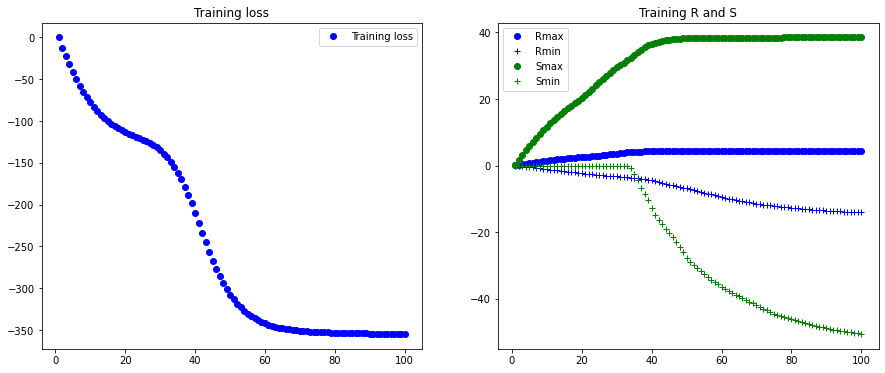

In [257]:
plotHistory(specProModel.history)

### Visualize resulting profiles as sequence logos

In [258]:
printExpectedPatterns()

Desired: ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']
Repeat: ['REPEATAEPER', 'ENLKLLLNLK', 'RT*SYC*T*K', 'SFRFSSSFRFS', 'LSGSAVASGS', 'FQVQQ*LQVL']


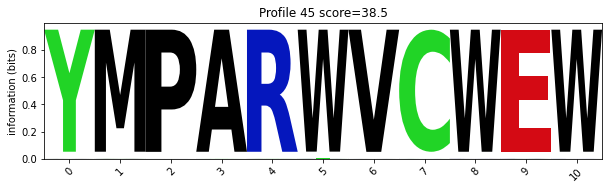

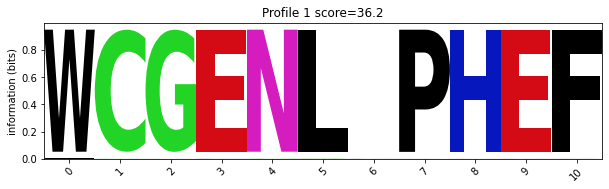

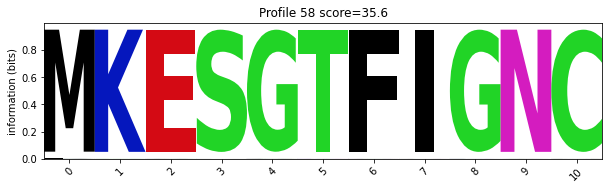

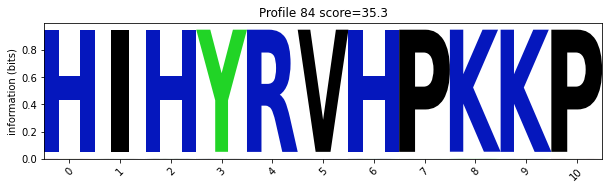

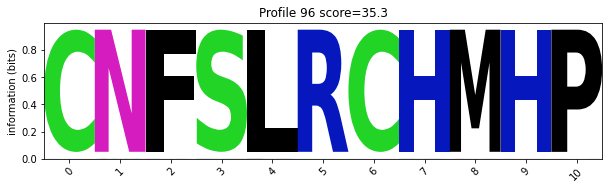

In [259]:
P = specProModel.getP()
pScores = specProModel.max_profile_scores(ds_score)
plotLogo(P=P, idxarray = np.argsort(-pScores), pScores=pScores, max_print=5)

---

## Profile Score Distribution

In [260]:
R = specProModel.getR()
minscore = np.array(R).min() * specProModel.k # profile matches not at all
maxscore = np.array(R).max() * specProModel.k # all bases match perfectly
print(minscore, ",", maxscore)
minscore = np.math.floor(minscore)
maxscore = np.math.floor(maxscore)

-151.97061824798584 , 48.50876045227051


     P:     (k, alphSize, U) 
     X:     (tilesPerX, N, 6, T, alphSize) 
     Z:     (tilesPerX, N, 6, T-k+1, U)
     S:     (tilesPerX, N, U)

In [261]:
scoreBins = dict([(b,0) for b in range(minscore, maxscore)])
assert k == R.shape[0]
Scollect = []

ds_score = getDataset().batch(batch_size).prefetch(150)
for batch in ds_score:
    for X in batch:
        S, _, Z = specProModel(X)
        Scollect.extend(np.array(S).flatten())
        #for s in np.array(Z[:,:,:,:,:]).flatten():
        for s in np.array(S).flatten():
            score = np.math.floor(s)
            assert score in scoreBins, str(score)+" ("+str(s)+")"
            scoreBins[score] += 1

(array([5.39e+02, 1.37e+02, 9.00e+00, 1.00e+00, 0.00e+00, 1.12e+04,
        0.00e+00, 1.00e+00, 1.50e+01, 9.80e+01]),
 array([-50.76568  , -41.83975  , -32.91382  , -23.987886 , -15.061955 ,
         -6.1360245,   2.7899063,  11.7158375,  20.641768 ,  29.5677   ,
         38.49363  ], dtype=float32),
 <BarContainer object of 10 artists>)

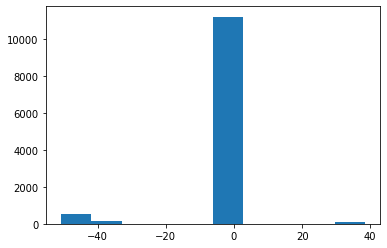

In [262]:
plt.hist(Scollect)

<BarContainer object of 200 artists>

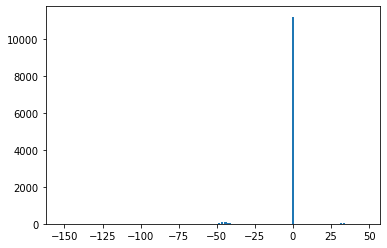

In [263]:
plt.bar(list(scoreBins.keys()), [scoreBins[k] for k in scoreBins])

---

### Profile Match Sites

In [264]:
ds_sites = getDataset().batch(batch_size).prefetch(150)
sites = specProModel.get_profile_match_sites(ds_sites, 1, tile_size, genomes)
sites

{32: {0: {0: [585]}},
 78: {1: {0: [270]}},
 84: {2: {0: [885]}},
 45: {3: {0: [906]}},
 1: {4: {0: [930]}},
 58: {5: {0: [45]}},
 96: {6: {0: [276]}},
 28: {7: {0: [636]}}}

---

## Find Best Profiles

Idea: 
* convert profiles into aa-sequences (translate max. values into aa at each position)
* align (or perfect match?) sequences against the 6 possible pattern translations and the insert translations
* alignment scores give an idea of how good the profiles are -> allows multiple training runs to account for randomness, evaluate how good the profiles usually are (+ variance)

In [265]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

In [266]:
def runTraining():
    tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models
    
    # build and randomly initialize profile model
    specProModel = SpecificProfile(k, su.aa_alphabet_size, U, Q)
    
    #start = time()
    specProModel.train_ds(ds, steps_per_epoch, epochs=500, verbose=False)
    #end = time()
    #print(f"time: {end-start:.2f}")
    
    #S, R = specProModel(X)
    #_, (L1, L2, L4, L7) = specProModel.loss(S)
    #pScores = tf.reduce_sum(tf.reduce_max(S,axis=0), axis=0).numpy()
    #print("pScores", pScores)
    #np.argsort(pScores)
    #print ("loss=", L1.numpy(), "\tL2=", L2.numpy(), 
    #       "\tL4=", L4.numpy(), "\nS=", S.numpy())
    
    P = specProModel.getP()
    
    return P

In [267]:
def aaFromProfiles(P):
    profiles_aa = []
    for pidx in range(P.shape[2]):
        pmat = P[:,:,pidx]
        profiles_aa.append(su.to_aa_seq(pmat))

    return profiles_aa

In [268]:
def getBestAlignments(profiles, patterns, scoreThreshold = int(k/2)):
    scores = []
    alignments = []
    best_profiles = []
    for profile in profiles:
        pscores = []
        palignments = []
        for pattern in patterns:
            als = pairwise2.align.localxd(profile, pattern, openA=-1000, extendA=-1000, openB=-1000, extendB=-1000)
            s = [al.score for al in als]
            if len(s) > 0:
                pscores.append(np.argmax(s))
                palignments.append(als[np.argmax(s)])

        best_al = palignments[np.argmax(pscores)]
        if best_al.score >= scoreThreshold:
            scores.append(best_al.score)
            alignments.append(best_al)
            best_profiles.append(profile)

    if len(scores) > 0:
        sortedIdx = np.argsort([-s for s in scores])
        scores = [scores[i] for i in sortedIdx]
        alignments = [alignments[i] for i in sortedIdx]
        best_profiles = [best_profiles[i] for i in sortedIdx]
    
    return scores, alignments, best_profiles

In [271]:
if False:
    for i in range(20):
        P = runTraining()
        profiles = aaFromProfiles(P)
        print("Run", i)
        if insertPatterns is not None:
            print("Desired profiles:")
            patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA)
            for i in range(len(patternScores)):
                    print(patternProfiles[i])
                    print(format_alignment(*(patternAlignments[i])))

        if repeatPatterns is not None:
            print("Undesired profiles:")
            repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA)
            for i in range(len(repeatScores)):
                    print(repeatProfiles[i])
                    print(format_alignment(*(repeatAlignments[i])))

        print("")
        print("-----")
        print("")
        
else:
    P = specProModel.getP()
    profiles = aaFromProfiles(P)

    if insertPatterns is not None:
        print("Desired profiles:")
        patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA, scoreThreshold=4)
        for i in range(len(patternScores)):
                print(patternProfiles[i])
                print(format_alignment(*(patternAlignments[i])))

    if repeatPatterns is not None:
        print("Undesired profiles:")
        repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA, scoreThreshold=4)
        for i in range(len(repeatScores)):
            print(repeatProfiles[i])
            print(format_alignment(*(repeatAlignments[i])))

Desired profiles:
EF*SGMARIQS
6 MARIQS
  ||||||
1 MARIQS
  Score=6

AANQTDAEDEQ
1 AANQTDAEDE
  |..|..|..|
2 ARIQSTANKE
  Score=4

AKAQSALSFET
1 AKAQSALSFE
  |..||....|
2 ARIQSTANKE
  Score=4

Undesired profiles:
QETESETAPER
2 ETESETAPER
  |.|....|||
2 EPEATAEPER
  Score=5

RKPCFIFEPEI
1 RKPCFIFEPE
  |.|....|||
1 REPEATAEPE
  Score=5

L*LILQLIGSL
1 L*LILQL
  |.|.|.|
3 LKLLLNL
  Score=4

NVELHQKEPER
8 EPER
  ||||
8 EPER
  Score=4

RRIRNTCLPLR
RRIRNTCLPLR
|....|..|.|
REPEATAEPER
  Score=4



In [272]:
R = specProModel.getR()
profiles = aaFromProfiles(R)
if insertPatterns is not None:
    print("Desired profiles:")
    patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA, scoreThreshold=4)
    for i in range(len(patternScores)):
            print(patternProfiles[i])
            print(format_alignment(*(patternAlignments[i])))

if repeatPatterns is not None:
    print("Undesired profiles:")
    repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA, scoreThreshold=4)
    for i in range(len(repeatScores)):
        print(repeatProfiles[i])
        print(format_alignment(*(repeatAlignments[i])))

Desired profiles:
EF*SGMARIQS
6 MARIQS
  ||||||
1 MARIQS
  Score=6

AANQTDAEDEQ
1 AANQTDAEDE
  |..|..|..|
2 ARIQSTANKE
  Score=4

AKAQSALSFET
1 AKAQSALSFE
  |..||....|
2 ARIQSTANKE
  Score=4

Undesired profiles:
QETESETAPER
2 ETESETAPER
  |.|....|||
2 EPEATAEPER
  Score=5

RKPCFIFEPEI
1 RKPCFIFEPE
  |.|....|||
1 REPEATAEPE
  Score=5

L*LILQLIGSL
1 L*LILQL
  |.|.|.|
3 LKLLLNL
  Score=4

NVELHQKEPER
8 EPER
  ||||
8 EPER
  Score=4

RRIRNTCLPLR
RRIRNTCLPLR
|....|..|.|
REPEATAEPER
  Score=4

